# initialization

In [8]:
# loading required packages
require(readr)
require(tidyverse)
require(dplyr)
require(caret)
require(edgeR)
require(ggplot2)
require(pROC)
require(reshape2)
require(pROC)
require(readxl)
require(VennDiagram)
require(sva)
require(cluster)
require(ggpubr)
require(RUVSeq)
require(pROC)
require(randomForest)
require(stringr)
require(Boruta)
require(PRROC)
require(formattable)
require(IRdisplay)


Loading required package: readr



Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: caret

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: edgeR

Loading required package: limma

Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: reshape2


Attaching packa

# load functions

In [9]:
source('/storeData/home/xucongmin/R_functions_bulkRNA.R')

# Split samples, define independent test set

In [14]:
sample_info <- readRDS("/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/sample_info.rds")
colnames(sample_info)
table(sample_info$Type)

[1] "sample"               "客户原编号"           "病案号"              
 [4] "姓名"                 "样本来源"             "年龄"                
 [7] "性别"                 "院区"                 "T"                   
[10] "N"                    "M"                    "建模分组"            
[13] "疾病分组"             "病理信息"             "肠镜信息"            
[16] "文库ID"               "分析路径"             "Index号"             
[19] "提取.建库板号"        "提取方式"             "miRNA文库浓度.ng.μL."
[22] "建库方式"             "文库结构"             "miRNA测序芯片号"     
[25] "测序类型"             "所属项目"             "采集时间"            
[28] "miRNA样本处理时间"    "cfDNA测序芯片号"      "cfDNA文库浓度.ng.μL."
[31] "cfDNA样本处理时间"    "Type"                 "year"                
[34] "storeTime"


     AA  Cancer Control     IBD     SSA     Tis 
    172     371     237      41       7       5 

In [15]:
df = subset(sample_info, Type == 'Cancer'|Type == 'Control')
# Combine all balancing factors into a single column
df <- df %>%
  mutate(age_group = cut(年龄, breaks = seq(0, 100, by = 10), include.lowest = TRUE))

df$stratify_col <- interaction(df$Type, df$性别, df$age_group, drop = TRUE)

# Split the data into training (70%) and test (30%) sets
set.seed(123)  # For reproducibility
trainIndex <- createDataPartition(df$stratify_col, p = 0.7, list = FALSE)

# Create training and test datasets
train_data <- df[trainIndex, ]
test_data <- df[-trainIndex, ]

# Check proportions in training and test data
table(train_data$Type) / nrow(train_data)
table(test_data$Type) / nrow(test_data)

samples.train = train_data$sample
samples.test = test_data$sample


Warning message in createDataPartition(df$stratify_col, p = 0.7, list = FALSE):
“Some classes have a single record ( Cancer.Male.(90,100] ) and these will be selected for the sample”



   Cancer   Control 
0.6118721 0.3881279 


   Cancer   Control 
0.6058824 0.3941176 

In [16]:
saveRDS(samples.train,file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/training_samples.rds')

In [17]:
# Check proportions in training and test data
table(train_data$性别) / nrow(train_data)
table(test_data$性别) / nrow(test_data)

# Check proportions in training and test data
#table(train_data$年龄) / nrow(train_data)
#table(test_data$年龄) / nrow(test_data)

table(sample_info[samples.train, ]$year, sample_info[samples.train, ]$Type)
table(sample_info[samples.test, ]$year, sample_info[samples.test, ]$Type)





   Female      Male 
0.4041096 0.5958904 


Female   Male 
   0.4    0.6 

      
       Cancer Control
  2022     96     101
  2023    172      69

      
       Cancer Control
  2022     40      40
  2023     63      27

# UMI umitools, directional - matrix

In [5]:
exp_matrix_list = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/exp_matrix_list.rds')

list2env(exp_matrix_list, .GlobalEnv)

<environment: R_GlobalEnv>

In [4]:
head(raw_ruvg)
dim(raw_ruvg)

head(isogroup_raw_ruvg)
dim(isogroup_raw_ruvg)

P2107060012 P2107060015
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p   2           1         
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p   2           1         
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p  10           6         
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p  15          67         
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p  3           2         
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p  68          32         
                                                P2107060041 P2107060042
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p   1           1         
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p   1           1         
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p   2           3         
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p  30          62         
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p  1           1         
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p   7          89         
                                                P2107060046 P2107060050
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p   0           1         
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p   0           1         
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p   1           5         
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p  35           7         
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p  1           2         
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p   4          23         
                                                P2107060059 P2107060060
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p   1           1         
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p   1           1         
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p   3           4         
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p   4          46         
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p  1           2         
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p  12          18         
                                                P2107060099 P2107060100 ⋯
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p   0           0          ⋯
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p   0           0          ⋯
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p   0           2          ⋯
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p  15          93          ⋯
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p  0           9          ⋯
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p   1           4          ⋯
                                                P221214436 P221214437
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p  17          5        
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p  17          5        
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p   6          7        
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p  10         13        
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p 11         18        
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p  12         21        
                                                P221214438 P221214439
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p   0          0        
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p   0          0        
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p  24         13        
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p  14         14        
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p 34         20        
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p  33         24        
                                                P221214440 P221214441
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p   0          2        
iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p   0          2        
iso-16-036X19D_ACAGTGGCTAAGTTCC_hsa-miR-27a-3p  15         13        
iso-16-03H2X4E_ACAGTATAGATGATGT_hsa-miR-144-3p  28          5        
iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p 10         19        
iso-16-0M4F49B_ACATCCTACACTCTCA_hsa-miR-30c-5p  14         19        
                                            

[1] 6870  833

P2107060012 P2107060015 P2107060041 P2107060042 P2107060046
hsa-let-7a-3p  299        423         422         325         281        
hsa-let-7a-5p 1363        791         762         761         542        
hsa-let-7b-3p   28         30          20          13          13        
hsa-let-7b-5p  420        407         292         227         302        
hsa-let-7c-5p  169         70          38           8           7        
hsa-let-7d-3p  204        196         133         108          95        
              P2107060050 P2107060059 P2107060060 P2107060099 P2107060100 ⋯
hsa-let-7a-3p 408         405          234         163         294        ⋯
hsa-let-7a-5p 849         692         1001        1173        1427        ⋯
hsa-let-7b-3p  21          24           15          20           9        ⋯
hsa-let-7b-5p 412         470          462         584         468        ⋯
hsa-let-7c-5p  86          15           55          56          31        ⋯
hsa-let-7d-3p 112         120          206          83         203        ⋯
              P221214436 P221214437 P221214438 P221214439 P221214440 P221214441
hsa-let-7a-3p 308         340        385        358        233        392      
hsa-let-7a-5p 932        2830       2783       1517       1078       4403      
hsa-let-7b-3p  10          23         22         25         32         19      
hsa-let-7b-5p 317         756        628        432        396       1028      
hsa-let-7c-5p  27          57         81         49         44        123      
hsa-let-7d-3p 241         389        397        366        618        724      
              P221214442 P221214443 P221214444 P221214445
hsa-let-7a-3p  478        419        325        414      
hsa-let-7a-5p 3817       3437       1671       2618      
hsa-let-7b-3p   33         26         18         28      
hsa-let-7b-5p 1043        863        517        583      
hsa-let-7c-5p  113        120         71         65      
hsa-let-7d-3p  730        619        260        566

[1] 416 833

In [8]:
sum(grep('has', rownames(raw_ruvg)))

[1] 0

In [9]:
raw_ruvg[grep('hsa-miR-500b-5p', rownames(raw_ruvg)), ]
isogroup_raw_ruvg[grep('hsa-miR-500b-5p', rownames(isogroup_raw_ruvg)), ]


P2107060012 P2107060015 P2107060041 P2107060042 P2107060046 P2107060050 
          3           2           1           1           1           2 
P2107060059 P2107060060 P2107060099 P2107060100 P2107060101 P2107060102 
         37           2           0           1           0           1 
P2107060103 P2107060104 P2107060105 P2107060106 P2107060107 P2107060108 
         26           0           0           1           0           0 
P2107060110 P2107060111 P2107060112 P2107060113 P2107060114 P2107060116 
         17          36           0           1           0           0 
P2107060118 P2107060119 P2107060120 P2107060121 P2107060122 P2107060123 
          1           0           0           1           1           0 
P2107060125 P2107060126 P2107060127 P2107060128 P2107060129 P2107060130 
          0           0           0           0           0           1 
P2107060132 P2107060133 P2107060134 P2107060135 P2107060136 P2107060137 
          2           1           1           1           0          13 
P2107060138 P2107060140 P2107060141 P2107060142 P2107060143 P2107060144 
          0           0           0           0           0           1 
P2107060145 P2107060146 P2107060147 P2107060148 P2107060149 P2107060150 
          1           0           0           0           1           0 
P2107060151 P2107060152 P2107060154 P2107060155 P2107060156 P2107060157 
          1           0           1           0           0           0 
P2107060158 P2107060159 P2107060160 P2107060161 P2107060162 P2107060163 
          1           1           1           1           1           3 
P2107060164 P2107060165 P2107060167 P2107060168 P2107060169 P2107060171 
          1           1           0          10           0           2 
P2107060172 P2107060173 P2107060174 P2107060175 P2107060176 P2107060177 
          0           0           0           1           0           0 
P2107060178 P2107060179 P2107060180 P2107060181 P2107060182 P2107060183 
          0           0           0           0           0           0 
P2107060184 P2107060185 P2107060186 P2107060187 P2107060188 P2107060189 
          0           0           1           0           0           1 
P2107060190 P2107060191 P2107060192 P2107060193 P2107060194 P2107060195 
          8           0           2           1           0           1 
P2107060196 P2107060197 P2107060198 P2107060199 P2107060201 P2107060202 
          0           0           0           0           0           0 
P2107060203 P2107060204 P2107060205 P2107060206 P2107060207 P2107060208 
          0           1           0           0           0           0 
P2107060209 P2107060210 P2107060211 P2107060212 P2107060213 P2107060214 
          2           0           0           1           0           0 
P2107060215 P2107060216 P2107060217 P2107060219 P2107060220 P2107060221 
          0           0          18           0           0           0 
P2107060222 P2107060223 P2107060224 P2107060227 P2107060228 P2107060229 
          0           0           0           0           0           0 
P2107060231 P2107060232 P2107060234 P2107060235 P2107060236 P2107060237 
          0          15           0          13           0           0 
P2107060238 P2107060239 P2107060240 P2107060241 P2107060243 P2107060244 
          0          14           0           0          18           0 
P2107060246 P2107060249 P2107060251 P2107060252 P2107060253 P2107060258 
          0          11           0           0           0           0 
P2107060259 P2107060261 P2107060264 P2107060265 P2107060266 P2107060267 
          0           0           0           0           0           0 
P2107060268 P2107060269 P2107060270 P2107060271 P2107060272 P2107060273 
          0           1           0           0           0           0 
P2107060274 P2107060278 P2107060280 P2107060283 P2107060284 P2107060285 
          0           1           0           0           0           0 
P2107060286 P2107060287 P2107060288 P2107060289 P210706029

P2107060012 P2107060015 P2107060041 P2107060042 P2107060046
hsa-miR-500b-5p 3           2           1           1           1          
                P2107060050 P2107060059 P2107060060 P2107060099 P2107060100 ⋯
hsa-miR-500b-5p 2           37          2           0           1           ⋯
                P221214436 P221214437 P221214438 P221214439 P221214440
hsa-miR-500b-5p 3          2          2          2          0         
                P221214441 P221214442 P221214443 P221214444 P221214445
hsa-miR-500b-5p 1          0          4          0          0

In [62]:
exp_matrix_list = list()

## raw, cpm, irp

In [63]:
raw_data <- readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/12_UMI_mapping_position_directional_dedup_result/03.rerun.sum/isomiRs_833/raw_data.rds')
cpm <- readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/12_UMI_mapping_position_directional_dedup_result/03.rerun.sum/isomiRs_833/cpm.rds')
irp <- readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/12_UMI_mapping_position_directional_dedup_result/03.rerun.sum/isomiRs_833/irp.rds')

keep = rowSums(raw_data>=5)>= 0.1*ncol(raw_data) 
raw_data <- raw_data[keep, ]
cpm <- cpm[keep, ]
irp <- irp[keep, ]

sum(colnames(raw_data) == rownames(sample_info))

[1] 833

## Feature reduction
- only based on training samples

In [64]:
raw_data.train = raw_data[, samples.train]

sample_info.train = sample_info[samples.train, ]
sample.info.control = subset(sample_info.train, Type=='Control') 
sample.info.cancer = subset(sample_info.train, Type=='Cancer') 

raw_data_HC = raw_data.train[, sample.info.control$sample]
raw_data_CRC = raw_data.train[, sample.info.cancer$sample]

keep = rowSums(raw_data_HC>=5)>= 0.8*ncol(raw_data_HC)|rowSums(raw_data_CRC>=5)>= 0.8*ncol(raw_data_CRC)| # nolint
        rowSums(raw_data_HC>=15)>= 0.1*ncol(raw_data_HC)|rowSums(raw_data_CRC>=15)>= 0.1*ncol(raw_data_CRC) # nolint

feature_kept = rownames(raw_data)[keep]
saveRDS(feature_kept, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/feature_kept_train.rds')


In [65]:
raw_data <- raw_data[feature_kept, ]
cpm <- cpm[feature_kept, ]
irp <- irp[feature_kept, ]

exp_matrix_list[['raw_data']] = raw_data
exp_matrix_list[['cpm']] = cpm
exp_matrix_list[['irp']] = irp

In [66]:
dim(raw_data)

[1] 6870  833

## cpm_log, raw_log

In [67]:
cpm_log = log(cpm+0.1)
raw_log = log(raw_data+0.1)

exp_matrix_list[['cpm_log']] = cpm_log
exp_matrix_list[['raw_log']] = raw_log

## cpm_irp_combined

In [68]:
row.names(cpm)  <- paste0(row.names(cpm),"_cpm")
row.names(irp)  <- paste0(row.names(irp),"_irp")
cpm_irp_combined <- rbind(cpm,irp)

exp_matrix_list[['cpm_irp_combined']] = cpm_irp_combined

## isogroup_cpm, isogroup_cpm_combat, isogroup_raw, isogroup_raw_combat

In [69]:
isogroup_cpm = get_family_df(cpm)

x <- isogroup_cpm
batch <- factor(sample_info$year)
isogroup_cpm_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

isogroup_raw = get_family_df(raw_data)

x <- isogroup_raw
batch <- factor(sample_info$year)
isogroup_raw_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)


exp_matrix_list[['isogroup_cpm']] = isogroup_cpm
exp_matrix_list[['isogroup_cpm_combat']] = isogroup_cpm_combat
exp_matrix_list[['isogroup_raw']] = isogroup_raw
exp_matrix_list[['isogroup_raw_combat']] = isogroup_raw_combat

Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




## cpm_combat, cpm_log_combat

- cpm_combat_log failed, too few features

In [70]:
x <- cpm
batch <- factor(sample_info$year)
cpm_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

x <- cpm_log
batch <- factor(sample_info$year)
cpm_log_combat = ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

exp_matrix_list[['cpm_combat']] = cpm_combat
exp_matrix_list[['cpm_log_combat']] = cpm_log_combat

Found 2 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 2 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




## irp_combat

In [71]:
x <- irp
batch <- factor(sample_info$year)
irp_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

exp_matrix_list[['irp_combat']] = irp_combat

Found 2 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




## cpm_irp_combat_combined

In [72]:
cpm_irp_combat_combined = rbind(cpm_combat, irp_combat)

exp_matrix_list[['cpm_irp_combat_combined']] = cpm_irp_combat_combined

## raw_combat, raw_combat_cpm

In [73]:
x <- raw_data
batch <- factor(sample_info$year)
raw_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

raw_combat_cpm = calculate_cpm(raw_combat)

exp_matrix_list[['raw_combat']] = raw_combat
exp_matrix_list[['raw_combat_cpm']] = raw_combat_cpm

Found 2 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




## raw_ruvg, raw_ruvg_cpm, raw_ruvg_log

In [74]:
# hk.genes = c("hsa-miR-16-5p_delT_0_0", 
# "hsa-miR-15b-5p_0_delACA_0", 
# "hsa-miR-451a_delAAA_delT_0", 
# "hsa-miR-19a-3p_0_delGA_0", 
# "hsa-miR-15a-5p_delTAG_delG_0", 
# "hsa-miR-32-5p_0_delCA_0", 
# "hsa-let-7i-5p_0_delT_0", 
# "hsa-miR-27a-3p_0_0_21CA", 
# "hsa-miR-29c-3p_0_delA_0", 
# "hsa-miR-140-3p_delT_insAC_0")

hk.genes = c("CAGCACGTAAATATTGGCG", 
  "TAGCAGCACATCATGGTTT", 
  "CCGTTACCATTACTGAGT", 
  "TGTGCAAATCTATGCAAAACT", 
  "CAGCACATAATGGTTTGT", 
  "TATTGCACATTACTAAGTTG", 
  "TGAGGTAGTAGTTTGTGCTGT", 
  "TTCACAGTGGCTAAGTTCCGA", 
  "TAGCACCATTTGAAATCGGTT", 
  "ACCACAGGGTAGAACCACGGAC")

sequences_to_find = paste0('_',hk.genes,'_')

# Find row names containing any of the sequences
matching_rows <- rownames(raw_data)[grep(paste(sequences_to_find, collapse="|"), rownames(raw_data))]

# Print matching rows
hk.genes = matching_rows

dge <- DGEList(counts = raw_data)
set <- newSeqExpressionSet(as.matrix(raw_data), phenoData = data.frame(row.names = colnames(raw_data)))
set_ruvg <- RUVg(set, hk.genes, k = 1)  
# k = 1 means the first factor of unwanted variation will be removed
# You can increase k if you believe more unwanted variation needs to be accounted for.

raw_ruvg <- normCounts(set_ruvg)

raw_ruvg_cpm = calculate_cpm(raw_ruvg)

raw_ruvg_log = log(raw_ruvg+0.1)


exp_matrix_list[['raw_ruvg']] = raw_ruvg
exp_matrix_list[['raw_ruvg_cpm']] = raw_ruvg_cpm
exp_matrix_list[['raw_ruvg_log']] = raw_ruvg_log

## raw_ruvg_combat

In [75]:
x <- raw_ruvg
batch <- factor(sample_info$year)
raw_ruvg_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

exp_matrix_list[['raw_ruvg_combat']] = raw_ruvg_combat

Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




## mature_cpm, mature_cpm_combat, mature_raw, mature_raw_combat

In [76]:
mature_seq = readLines('/storeData/project/19-preRD_isomir_CRC/code_figures/9_iso_vs_readscount/hsa.mature.seq.list')
sequences_to_find = paste0('_',mature_seq,'_')
# Find row names containing any of the sequences
#matching_rows <- rownames(cpm)[grep(paste(sequences_to_find, collapse="|"), rownames(cpm))]

# Search for rows matching any sequence
matching_rows <- which(str_detect(rownames(cpm), paste(sequences_to_find, collapse = "|")))

# Subset the cpm matrix based on the matching rows
mature_cpm <- cpm[matching_rows, ]

# Search for rows matching any sequence
matching_rows <- which(str_detect(rownames(cpm_combat), paste(sequences_to_find, collapse = "|")))

# Subset the cpm matrix based on the matching rows
mature_cpm_combat <- cpm_combat[matching_rows, ]

# Search for rows matching any sequence
matching_rows <- which(str_detect(rownames(raw_data), paste(sequences_to_find, collapse = "|")))

# Subset the cpm matrix based on the matching rows
mature_raw <- raw_data[matching_rows, ]


# Search for rows matching any sequence
matching_rows <- which(str_detect(rownames(raw_combat), paste(sequences_to_find, collapse = "|")))

# Subset the cpm matrix based on the matching rows
mature_raw_combat <- raw_combat[matching_rows, ]


exp_matrix_list[['mature_cpm']] = mature_cpm
exp_matrix_list[['mature_cpm_combat']] = mature_cpm_combat
exp_matrix_list[['mature_raw']] = mature_raw
exp_matrix_list[['mature_raw_combat']] = mature_raw_combat

## mature_raw_ruvg, isogroup_raw_ruvg

In [77]:
mature_seq = readLines('/storeData/project/19-preRD_isomir_CRC/code_figures/9_iso_vs_readscount/hsa.mature.seq.list')
sequences_to_find = paste0('_',mature_seq,'_')
# Find row names containing any of the sequences
#matching_rows <- rownames(cpm)[grep(paste(sequences_to_find, collapse="|"), rownames(cpm))]

# Search for rows matching any sequence
matching_rows <- which(str_detect(rownames(raw_ruvg), paste(sequences_to_find, collapse = "|")))

# Subset the cpm matrix based on the matching rows
mature_raw_ruvg <- raw_ruvg[matching_rows, ]

isogroup_raw_ruvg = get_family_df(raw_ruvg)

In [78]:
head(mature_raw_ruvg)
dim(mature_raw_ruvg)
head(isogroup_raw_ruvg)
dim(isogroup_raw_ruvg)

P2107060012 P2107060015
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136    1          1          
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 69          4          
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    69          4          
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246    1          1          
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b   1          1          
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665    1          1          
                                                   P2107060041 P2107060042
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136   0            0         
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 2           28         
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    2           28         
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246   0            0         
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b  0            0         
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665   0            0         
                                                   P2107060046 P2107060050
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136   0            1         
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 1           42         
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    1           42         
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246   0            0         
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b  0            0         
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665   0            1         
                                                   P2107060059 P2107060060
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136    0          1          
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 93          3          
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    93          3          
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246    0          0          
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b   0          0          
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665    0          0          
                                                   P2107060099 P2107060100 ⋯
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136    0           2          ⋯
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 36          40          ⋯
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    36          40          ⋯
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246    0           0          ⋯
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b   0           0          ⋯
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665    0           0          ⋯
                                                   P221214436 P221214437
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136   12          9        
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 47         36        
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    47         36        
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246    0          0        
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b   5         21        
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665    3         13        
                                                   P221214438 P221214439
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136    8         15        
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 42         39        
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    42         39        
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246    0          0        
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b  19         17        
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665    6         19        
                                                   P221214440 P221214441
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136    5          6        
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p 98         37        
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b    98         37        
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246    0          0        
iso-19-HR05X61I_ATCCCACCA

[1] 286 833

P2107060012 P2107060015 P2107060041 P2107060042 P2107060046
hsa-let-7a-3p  299        423         422         325         281        
hsa-let-7a-5p 1363        791         762         761         542        
hsa-let-7b-3p   28         30          20          13          13        
hsa-let-7b-5p  420        407         292         227         302        
hsa-let-7c-5p  169         70          38           8           7        
hsa-let-7d-3p  204        196         133         108          95        
              P2107060050 P2107060059 P2107060060 P2107060099 P2107060100 ⋯
hsa-let-7a-3p 408         405          234         163         294        ⋯
hsa-let-7a-5p 849         692         1001        1173        1427        ⋯
hsa-let-7b-3p  21          24           15          20           9        ⋯
hsa-let-7b-5p 412         470          462         584         468        ⋯
hsa-let-7c-5p  86          15           55          56          31        ⋯
hsa-let-7d-3p 112         120          206          83         203        ⋯
              P221214436 P221214437 P221214438 P221214439 P221214440 P221214441
hsa-let-7a-3p 308         340        385        358        233        392      
hsa-let-7a-5p 932        2830       2783       1517       1078       4403      
hsa-let-7b-3p  10          23         22         25         32         19      
hsa-let-7b-5p 317         756        628        432        396       1028      
hsa-let-7c-5p  27          57         81         49         44        123      
hsa-let-7d-3p 241         389        397        366        618        724      
              P221214442 P221214443 P221214444 P221214445
hsa-let-7a-3p  478        419        325        414      
hsa-let-7a-5p 3817       3437       1671       2618      
hsa-let-7b-3p   33         26         18         28      
hsa-let-7b-5p 1043        863        517        583      
hsa-let-7c-5p  113        120         71         65      
hsa-let-7d-3p  730        619        260        566

[1] 416 833

In [79]:
exp_matrix_list[['mature_raw_ruvg']] = mature_raw_ruvg
exp_matrix_list[['isogroup_raw_ruvg']] = isogroup_raw_ruvg

In [80]:
saveRDS(exp_matrix_list, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/exp_matrix_list.rds')

# DE, training samples only

In [23]:
de_genes_list = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/de_genes_list.rds')
de_genes_rownames <- lapply(de_genes_list, rownames)

# Optionally, assign each back to its original variable
list2env(de_genes_rownames, .GlobalEnv)

<environment: R_GlobalEnv>

## w-rank sum

In [26]:
de_wrank = function(input.df, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1){
      train.df = input.df[, samples.train]
      
      count_matrix = as.matrix(train.df)
      
      groups = sample_info[samples.train, ]$Type

      # Apply the Wilcoxon rank sum test using apply
      results <- apply(count_matrix, 1, function(x) {
        wilcox_test <- wilcox.test(x ~ groups)
        logFC <- calculate_logFC(x, groups)
        return(list(p_value = wilcox_test$p.value, logFC = logFC))
      })

      p_values <- sapply(results, function(res) res$p_value)
      logFC_values <- sapply(results, function(res) res$logFC)

      # Adjust p-values for multiple testing
      p_adj <- p.adjust(p_values, method = "fdr")

      de_result = data.frame(pValue = p_values, p.adjust = p_adj, logFC = logFC_values)
      rownames(de_result) = rownames(count_matrix)

      de_genes = subset(de_result, p_adj<p_thred&abs(logFC)>logFC_thred)

      return(de_genes)
}
       

## EdgeR

In [33]:
de_edgeR = function(input.df, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1){

train.df = input.df[, samples.train]

group = factor(sample_info[samples.train, ]$Type, levels = c("Control", "Cancer"))

# Create DGEList object
y <- DGEList(counts = train.df, group = group)

# Normalize the data
y <- calcNormFactors(y)

# Create design matrix
design <- model.matrix(~ 0 + group)
colnames(design) <- levels(group)

# Estimate dispersions
y <- estimateDisp(y, design)

# Fit the model
fit <- glmQLFit(y, design)

# Set contrast (Cancer vs Control, for example)
contrast <- makeContrasts(Cancer - Control, levels = design)

# Test the contrast
qlf <- glmQLFTest(fit, contrast = contrast)

de_result = qlf$table

de_genes = subset(de_result, PValue<p_thred&abs(logFC)>logFC_thred)

return(de_genes)

}
       

## generate de gene list

In [3]:
de_genes_list = readRDS(file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/de_genes_list.rds')

In [11]:
de_genes_mature_raw_ruvg_edger = readRDS(file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/mature_raw_ruvg_edger_result.rds')
head(de_genes_mature_raw_ruvg_edger)

de_genes_isogroup_raw_ruvg_edger = readRDS(file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/isogroup_raw_ruvg_edger_result.rds')
head(de_genes_isogroup_raw_ruvg_edger)

de_genes_raw_ruvg_edger = readRDS(file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/raw_ruvg_edger_result.rds')

logFC      logCPM  
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136   -0.4292532 5.664964
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p  0.2333099 9.040506
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b     0.2333099 9.040506
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246    3.8629065 6.930156
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b  -0.5881907 5.619422
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665   -0.9149696 5.201029
                                                   F          PValue      
iso-18-OB1690DV_GAAAAAGTCATGGAGGCC_hsa-miR-12136     6.614350 1.043959e-02
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151a-5p   3.027613 8.254979e-02
iso-18-W05I2P03_TCGAGGAGCTCACAGTCT_hsa-miR-151b      3.027613 8.254979e-02
iso-19-D8IZ90FY_AATGGATTTTTGGAGCAGG_hsa-miR-1246   114.538915 6.116156e-24
iso-19-HR05X61I_ATCCCACCACTGCCACCAT_hsa-miR-1260b   12.674613 4.105758e-04
iso-20-0P5JXKK7_ACCAGGAGGCTGAGGCCCCT_hsa-miR-665    29.453347 9.429975e-08

logFC     logCPM    F         PValue      
hsa-let-7a-3p 0.7270661  9.796983 124.78403 1.108230e-25
hsa-let-7a-5p 0.5968779 12.046984  71.22895 4.616175e-16
hsa-let-7b-3p 0.6851821  5.889837  75.95855 5.923442e-17
hsa-let-7b-5p 1.0039801 10.763199  78.26332 2.194035e-17
hsa-let-7c-5p 0.6396948  7.437124  50.10867 5.769417e-12
hsa-let-7d-3p 0.2386303  9.065437  29.73790 8.254751e-08

In [12]:
de_genes_raw_ruvg_edger[grep('hsa-miR-500b-5p', rownames(de_genes_raw_ruvg_edger)), ]
de_genes_isogroup_raw_ruvg_edger[grep('hsa-miR-500b-5p', rownames(de_genes_isogroup_raw_ruvg_edger)), ]


logFC     logCPM   F       
iso-16-NVU7R4B_CTTGCTACCTGGGTGA_hsa-miR-500b-5p 0.9309158 3.889096 12.86208
                                                PValue      
iso-16-NVU7R4B_CTTGCTACCTGGGTGA_hsa-miR-500b-5p 0.0003726476

logFC    logCPM   F        PValue      
hsa-miR-500b-5p 1.541922 3.914771 32.08323 2.668773e-08

In [35]:
de_genes_raw_ruvg_edger = de_edgeR(raw_ruvg, samples.train, sample_info, p_thred = 1, logFC_thred = 0)

saveRDS(de_genes_raw_ruvg_edger, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/raw_ruvg_edger_result.rds')

de_genes_mature_raw_ruvg_edger = de_edgeR(mature_raw_ruvg, samples.train, sample_info, p_thred = 1, logFC_thred = 0)

saveRDS(de_genes_mature_raw_ruvg_edger, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/mature_raw_ruvg_edger_result.rds')

de_genes_isogroup_raw_ruvg_edger = de_edgeR(isogroup_raw_ruvg, samples.train, sample_info, p_thred = 1, logFC_thred = 0)

saveRDS(de_genes_isogroup_raw_ruvg_edger, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/isogroup_raw_ruvg_edger_result.rds')

Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.ob

In [53]:
de_genes_list <- list(
  de_genes_raw_data = de_edgeR(raw_data, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_irp = de_wrank(irp, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_cpm = de_wrank(cpm, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_irp_cpm = de_wrank(cpm_irp_combined, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),

  de_genes_raw_combat = de_wrank(raw_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_irp_combat = de_wrank(irp_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_cpm_combat = de_wrank(cpm_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_irp_cpm_combat = de_wrank(cpm_irp_combat_combined, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),

  de_genes_raw_combat_cpm = de_wrank(raw_combat_cpm, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  
  de_genes_raw_ruvg_edger = de_edgeR(raw_ruvg, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_raw_ruvg_wrank = de_wrank(raw_ruvg, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_raw_ruvg_combat = de_wrank(raw_ruvg_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_raw_ruvg_cpm = de_wrank(raw_ruvg_cpm, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
 
  de_genes_mature_cpm = de_wrank(mature_cpm, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_mature_cpm_combat = de_wrank(mature_cpm_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_mature_raw = de_edgeR(mature_raw, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_mature_raw_combat = de_wrank(mature_raw_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  
  de_genes_isogroup_cpm = de_wrank(isogroup_cpm, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_isogroup_cpm_combat = de_wrank(isogroup_cpm_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_isogroup_raw = de_edgeR(isogroup_raw, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_isogroup_raw_combat = de_wrank(isogroup_raw_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),

  de_genes_raw_log = de_wrank(raw_log, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_cpm_log = de_wrank(cpm_log, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_raw_ruvg_log = de_wrank(raw_ruvg_log, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  
  de_genes_cpm_combat_log = de_wrank(cpm_combat_log, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1),
  de_genes_cpm_log_combat = de_wrank(cpm_log_combat, samples.train, sample_info, p_thred = 0.05, logFC_thred = 1)
  )

# Apply the rownames function to each list item
de_genes_rownames <- lapply(de_genes_list, rownames)

# Optionally, assign each back to its original variable
list2env(de_genes_rownames, .GlobalEnv)

saveRDS(de_genes_list, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/de_genes_list.rds')

Warning message in calculate_logFC(x, groups):
“NaNs produced”
Warning message in calculate_logFC(x, groups):
“NaNs produced”
Warning message in calculate_logFC(x, groups):
“NaNs produced”
Warning message in calculate_logFC(x, groups):
“NaNs produced”
Warning message in calculate_logFC(x, groups):
“NaNs produced”
Warning message in calculate_logFC(x, groups):
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i], ref = x[, refColumn], libsize.obs = lib.size[i], :
“NaNs produced”
Warning message in .calcFactorTMM(obs = x[, i],

<environment: R_GlobalEnv>

# train and eval models

### strategy I: top 10% most important features and intersection

In [5]:
results_list = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/train_eval_result_v2.rds')

## test with mature_cpm

In [27]:
sample_info$type.binary <- ifelse(sample_info$Type == "Cancer", 1, 
                                  ifelse(sample_info$Type == "Control", 0, NA))



In [34]:
results_v2 = train_eval_model_v2(mature_cpm[de_genes_mature_cpm, ], sample_info, samples.train, samples.test)
extract_metrics(results_v2)

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



threshold auc       sensitivity specificity
1 0.66      0.9446457 0.8823529   0.8151261

threshold auc       sensitivity specificity
1 0.5       0.9126938 0.8834951   0.8059701

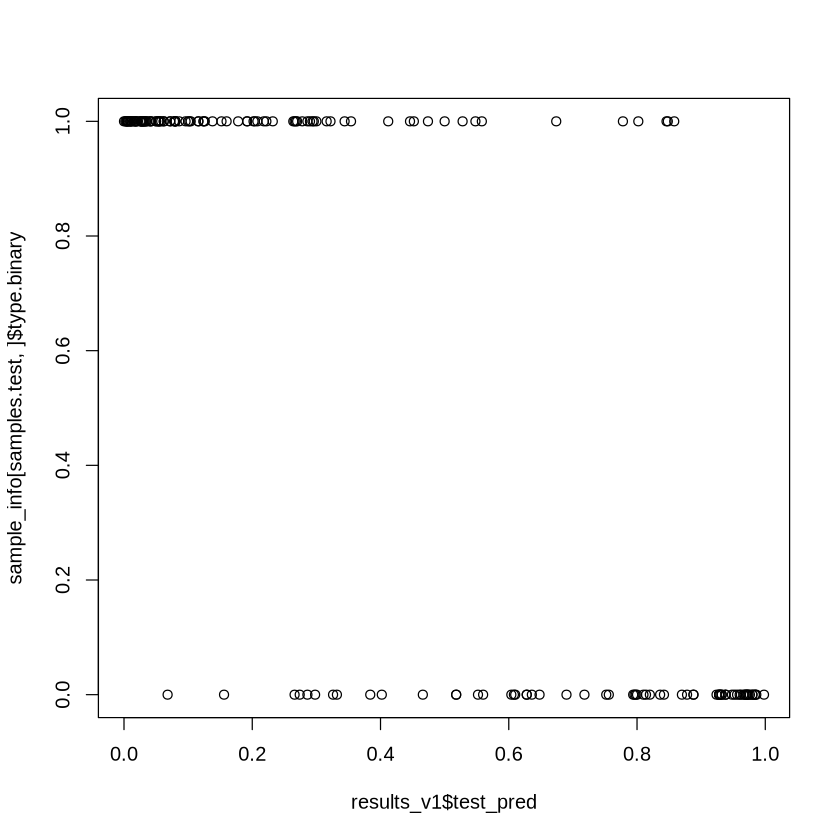

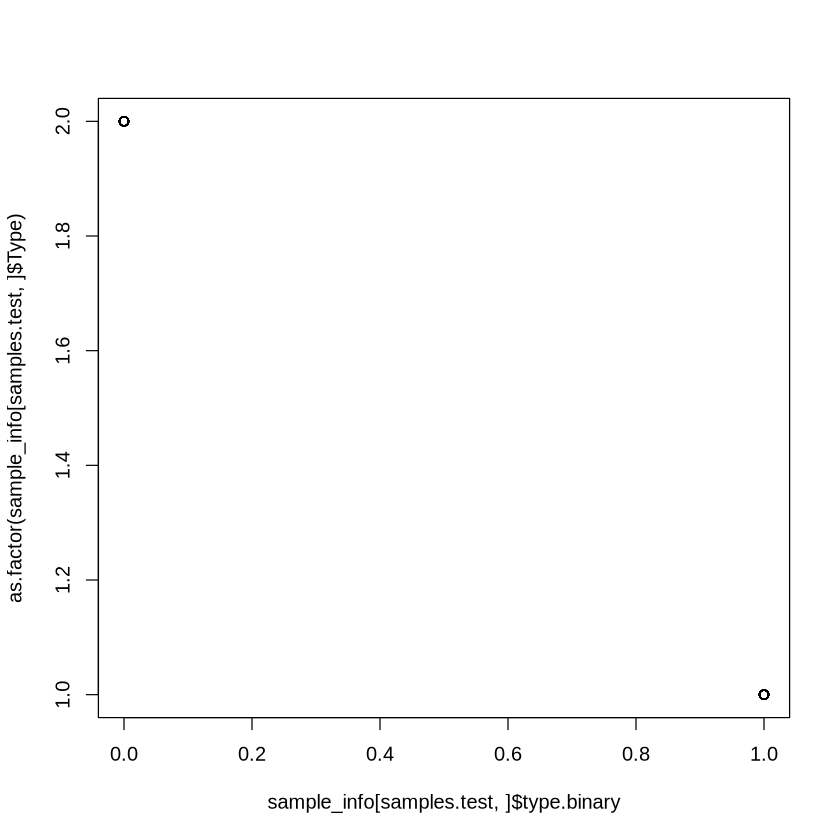

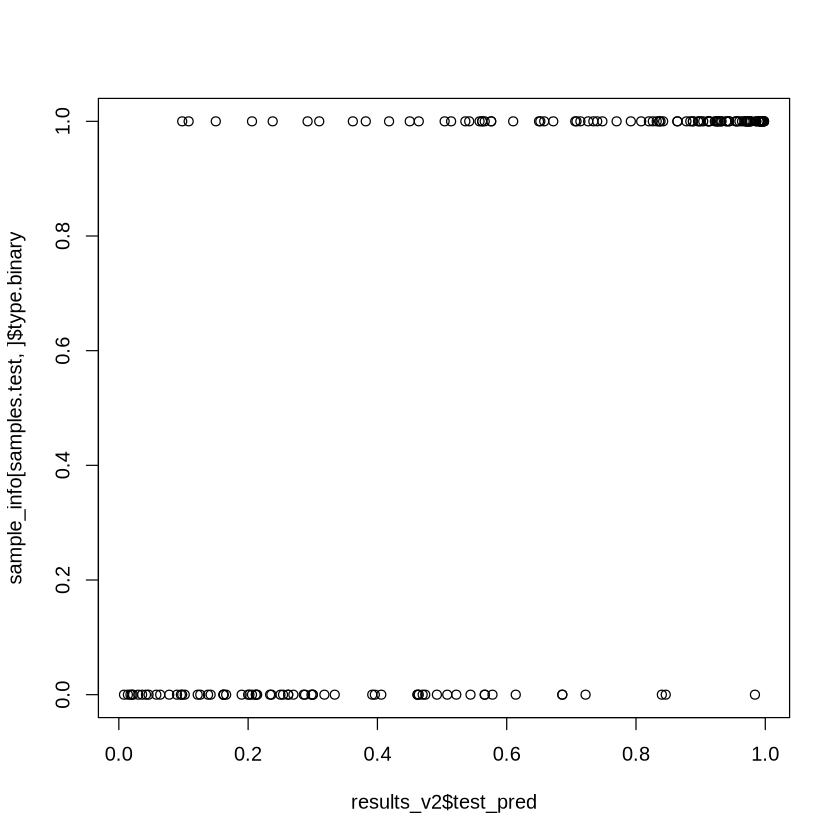

In [36]:
plot(sample_info[samples.test,]$type.binary, as.factor(sample_info[samples.test,]$Type))
plot(results_v2$test_pred, sample_info[samples.test,]$type.binary)


## run all matrix

In [8]:
sample_info$type.binary <- ifelse(sample_info$Type == "Cancer", 1, 
                                  ifelse(sample_info$Type == "Control", 0, NA))


In [34]:
data_list <- list(
    raw_data = raw_data[de_genes_raw_data, ],
    cpm = cpm[de_genes_cpm, ],
    irp = irp[de_genes_irp, ],
    cpm_irp_combined = cpm_irp_combined[de_genes_irp_cpm, ],
    
    cpm_combat = cpm_combat[de_genes_cpm_combat, ],
    irp_combat = irp_combat[de_genes_irp_combat, ],
    raw_combat = raw_combat[de_genes_raw_combat, ],
    cpm_irp_combat_combined = cpm_irp_combat_combined[de_genes_irp_cpm_combat, ],

    raw_combat_cpm = raw_combat_cpm[de_genes_raw_combat_cpm, ],

    raw_ruvg_edger = raw_ruvg[de_genes_raw_ruvg_edger, ],
    raw_ruvg_wrank = raw_ruvg[de_genes_raw_ruvg_wrank, ],
    raw_ruvg_combat = raw_ruvg_combat[de_genes_raw_ruvg_combat, ],
    raw_ruvg_cpm = raw_ruvg_cpm[de_genes_raw_ruvg_cpm, ],


    mature_cpm = mature_cpm[de_genes_mature_cpm, ],
    mature_cpm_combat = mature_cpm_combat[de_genes_mature_cpm_combat, ],
    mature_raw = mature_raw[de_genes_mature_raw, ],
    mature_raw_combat = mature_raw_combat[de_genes_mature_raw_combat, ],

    isogroup_cpm = isogroup_cpm[de_genes_isogroup_cpm, ],
    isogroup_cpm_combat = isogroup_cpm_combat[de_genes_isogroup_cpm_combat, ],
    isogroup_raw = isogroup_raw[de_genes_isogroup_raw, ],
    isogroup_raw_combat = isogroup_raw_combat[de_genes_isogroup_raw_combat, ],

    raw_log = raw_log[de_genes_raw_log, ],
    cpm_log = cpm_log[de_genes_cpm_log, ],
    raw_ruvg_log =raw_ruvg_log[de_genes_raw_ruvg_log, ],

    cpm_log_combat = cpm_log_combat[de_genes_cpm_log_combat, ]
    #cpm_combat_log = cpm_combat_log[de_genes_cpm_combat_log, ] ##it failed, only 4 differential features selected
    
)

# Applying the train_eval_model_v1 function using lapply
results_list <- lapply(data_list, function(data) {
  train_eval_model_v2(data, sample_info, samples.train, samples.test)
})


saveRDS(results_list,file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/train_eval_result_v2.rds')

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting leve

In [9]:
results_list = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/train_eval_result_v2.rds')

In [11]:

# Apply the function to all the results and combine them into a single dataframe
metrics_df <- do.call(rbind, lapply(results_list, extract_metrics))

# Add model names as a column
#metrics_df$model <- names(results_list)

metrics_df = metrics_df %>% 
mutate(youden = sensitivity + specificity)

metrics_df


threshold auc       sensitivity specificity
raw_data                0.5       0.9485582 0.9320388   0.8507463  
cpm                     0.5       0.9450080 0.8834951   0.8656716  
irp                     0.5       0.9503695 0.8834951   0.8805970  
cpm_irp_combined        0.5       0.9553688 0.9223301   0.8656716  
cpm_combat              0.5       0.9395740 0.9320388   0.8507463  
irp_combat              0.5       0.9297928 0.9320388   0.8059701  
raw_combat              0.5       0.9528329 0.9320388   0.8059701  
cpm_irp_combat_combined 0.5       0.9319664 0.9126214   0.8358209  
raw_combat_cpm          0.5       0.9421823 0.9029126   0.7761194  
raw_ruvg_edger          0.5       0.9653673 0.9223301   0.8059701  
raw_ruvg_wrank          0.5       0.9364585 0.9029126   0.8208955  
raw_ruvg_combat         0.5       0.9369657 0.8834951   0.8208955  
raw_ruvg_cpm            0.5       0.9101579 0.9029126   0.7164179  
mature_cpm              0.5       0.9126938 0.8834951   0.8059701  
mature_cpm_combat       0.5       0.9342849 0.8834951   0.8208955  
mature_raw              0.5       0.8886393 0.8932039   0.7164179  
mature_raw_combat       0.5       0.9042892 0.8640777   0.7164179  
isogroup_cpm            0.5       0.9337777 0.8834951   0.8208955  
isogroup_cpm_combat     0.5       0.8650920 0.8543689   0.7164179  
isogroup_raw            0.5       0.9422547 0.9126214   0.8358209  
isogroup_raw_combat     0.5       0.9401536 0.8932039   0.8059701  
raw_log                 0.5       0.9307347 0.9611650   0.8208955  
cpm_log                 0.5       0.9423997 0.9029126   0.8955224  
raw_ruvg_log            0.5       0.8859586 0.9029126   0.7313433  
cpm_log_combat          0.5       0.9297203 0.9126214   0.8656716  
                        num_initial_de_genes num_final_features train_auc
raw_data                3178                 38                 1        
cpm                     3094                 40                 1        
irp                     1518                 25                 1        
cpm_irp_combined        4613                 33                 1        
cpm_combat              2587                 13                 1        
irp_combat              1328                 18                 1        
raw_combat              2953                 23                 1        
cpm_irp_combat_combined 3914                 12                 1        
raw_combat_cpm          2933                 31                 1        
raw_ruvg_edger          2705                 14                 1        
raw_ruvg_wrank          3209                 11                 1        
raw_ruvg_combat         3133                 14                 1        
raw_ruvg_cpm            2716                 16                 1        
mature_cpm               163                 10                 1        
mature_cpm_combat        161                 10                 1        
mature_raw               100                  4                 1        
mature_raw_combat        189                 10                 1        
isogroup_cpm             175                  7                 1        
isogroup_cpm_combat      169                  5                 1        
isogroup_raw             162                 10                 1        
isogroup_raw_combat      206                  8                 1        
raw_log                 1400                 28                 1        
cpm_log                 1322                 26                 1        
raw_ruvg_log            1150                 13                 1        
cpm_log_combat          1265                  9                 1        
                        youden  
raw_data                1.782785
cpm                     1.749167
irp                     1.764092
cpm_irp_combined        1.788002
cpm_combat              1.782785
irp_combat              1.738009
raw_combat              1.738009
cpm_irp_combat_combined 1.748442
raw_combat_cpm          1.679032
ra

In [30]:
write.csv(metrics_df, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/model_comparison_metrics.csv')

In [36]:
highlight_max <- function(x) {
  formatter("span", style = x == max(x) ~ style(color = "green", font.weight = "bold"))
}

results = metrics_df
# Apply formattable to the dataframe and highlight the maximum values
formattable(results, 
            list(
              threshold = highlight_max(results$threshold),
              auc = highlight_max(results$auc),
              aupr = highlight_max(results$aupr),
              accuracy = highlight_max(results$accuracy),
              f1_score = highlight_max(results$f1_score),
              sensitivity = highlight_max(results$sensitivity),
              specificity = highlight_max(results$specificity)
            ))

threshold auc       sensitivity specificity
raw_data                0.5       0.9485582 0.9320388   0.8507463  
cpm                     0.5       0.9450080 0.8834951   0.8656716  
irp                     0.5       0.9503695 0.8834951   0.8805970  
cpm_irp_combined        0.5       0.9553688 0.9223301   0.8656716  
cpm_combat              0.5       0.9395740 0.9320388   0.8507463  
irp_combat              0.5       0.9297928 0.9320388   0.8059701  
raw_combat              0.5       0.9528329 0.9320388   0.8059701  
cpm_irp_combat_combined 0.5       0.9319664 0.9126214   0.8358209  
raw_combat_cpm          0.5       0.9421823 0.9029126   0.7761194  
raw_ruvg_edger          0.5       0.9653673 0.9223301   0.8059701  
raw_ruvg_wrank          0.5       0.9364585 0.9029126   0.8208955  
raw_ruvg_combat         0.5       0.9369657 0.8834951   0.8208955  
raw_ruvg_cpm            0.5       0.9101579 0.9029126   0.7164179  
mature_cpm              0.5       0.9126938 0.8834951   0.8059701  
mature_cpm_combat       0.5       0.9342849 0.8834951   0.8208955  
mature_raw              0.5       0.8886393 0.8932039   0.7164179  
mature_raw_combat       0.5       0.9042892 0.8640777   0.7164179  
isogroup_cpm            0.5       0.9337777 0.8834951   0.8208955  
isogroup_cpm_combat     0.5       0.8650920 0.8543689   0.7164179  
isogroup_raw            0.5       0.9422547 0.9126214   0.8358209  
isogroup_raw_combat     0.5       0.9401536 0.8932039   0.8059701  
raw_log                 0.5       0.9307347 0.9611650   0.8208955  
cpm_log                 0.5       0.9423997 0.9029126   0.8955224  
raw_ruvg_log            0.5       0.8859586 0.9029126   0.7313433

## TCGA markers, train and evaluate model performance

logFC     logCPM   LR        PValue        FDR          
ACGGAAGGGCAGAGAGGGCCAG -5.886203 4.672324 1754.5407  0.000000e+00  0.000000e+00
TTCACCACCTTCTCCACCCAGC -4.515426 8.284284 1082.1237 2.536397e-237 4.177445e-234
TTCACCACCTTCTCCACCCAG  -4.436386 5.391206 1079.4446 9.694343e-237 1.064439e-233
CGGAAGGGCAGAGAGGGCCAG  -4.905344 2.053820 1023.8846 1.155261e-224 9.513573e-222
CTATACGACCTGCTGCCTTTC  -3.868403 6.822817  917.1863 1.802084e-201 1.187213e-198
CTGGAGACACGTGCACTGTAGA -4.945156 4.642677  839.2372 1.590137e-184 8.729852e-182
                       Regulation
ACGGAAGGGCAGAGAGGGCCAG Down      
TTCACCACCTTCTCCACCCAGC Down      
TTCACCACCTTCTCCACCCAG  Down      
CGGAAGGGCAGAGAGGGCCAG  Down      
CTATACGACCTGCTGCCTTTC  Down      
CTGGAGACACGTGCACTGTAGA Down

[1] 1331

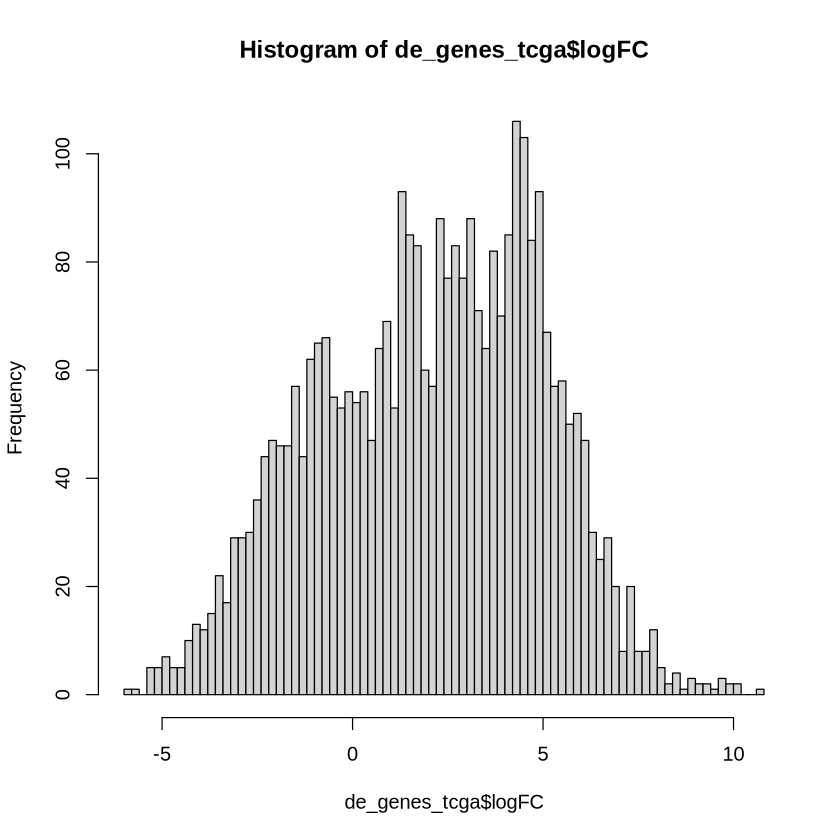

In [1]:
de_genes_tcga = readRDS('/storeData/project/user/anxiaolong/work/make_data/CRC/model_result/TCGA/data/TCGA_CRC_expression_label_select_0.1_5_genes_result.rds')
head(de_genes_tcga)
hist(de_genes_tcga$logFC, 100)
de_genes_tcga = rownames(subset(de_genes_tcga, abs(logFC)>3&FDR<0.001))
length(de_genes_tcga)

In [24]:
head(de_genes_raw_ruvg_edger)

[1] "iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27a-3p" 
[2] "iso-16-036X19B_ACAGTGGCTAAGTTCA_hsa-miR-27b-3p" 
[3] "iso-16-0DNID4B_ACAACCTGCTAAGTGA_hsa-miR-374c-5p"
[4] "iso-16-0M4F4PD_ACATCCTACACTCAGC_hsa-miR-30b-5p" 
[5] "iso-16-0Z46KPD_ACCTTCTCCACCCAGC_hsa-miR-197-3p" 
[6] "iso-16-1840YRD_AGTGGCTAAGTTCCCC_hsa-miR-27a-3p"

In [25]:
de_genes_raw_ruvg_edger.sub = gsub("^[^_]*_([^_]*)_.*$", "\\1", de_genes_raw_ruvg_edger)


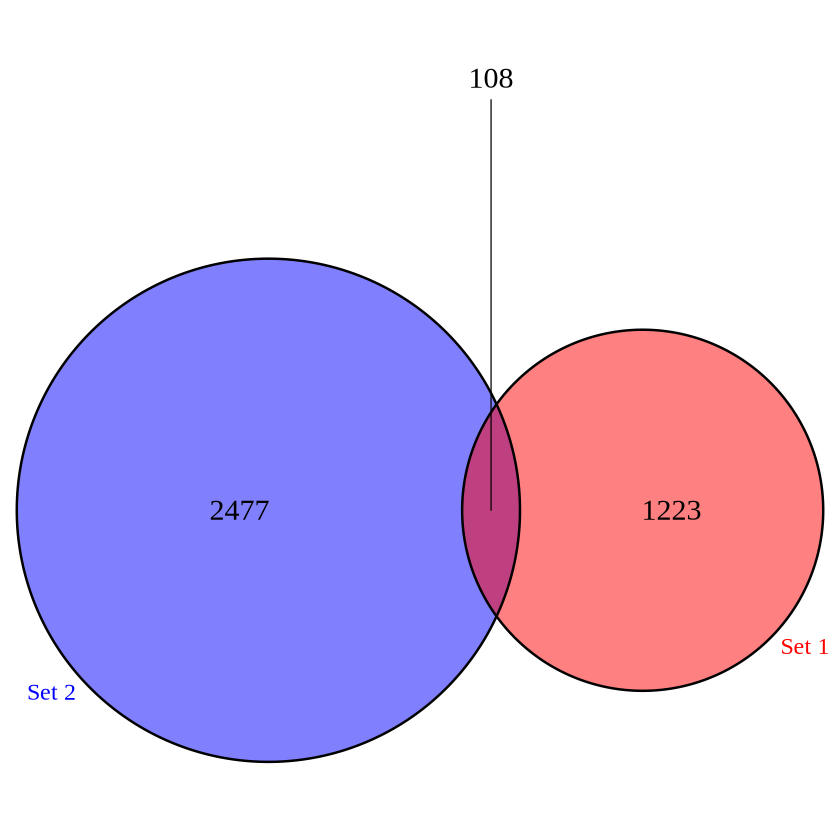

In [31]:
venn.plot <- venn.diagram(
  x = list(Set1 = de_genes_tcga, Set2 = de_genes_raw_ruvg_edger.sub),
  category.names = c("Set 1", "Set 2"),
  fill = c("red", "blue"),
  alpha = 0.5,
  cex = 1.5,
  cat.cex = 1.2,
  cat.col = c("red", "blue"),
  filename = NULL  # Prevents automatic saving to file
)

# Plot the Venn diagram
grid.draw(venn.plot)

In [32]:
input.df = raw_ruvg
rownames(input.df) = gsub("^[^_]*_([^_]*)_.*$", "\\1", rownames(input.df))

de_genes_tcga.intesected = intersect(rownames(input.df), de_genes_tcga)

In [33]:
modeling_result_tcga = train_eval_model_v2(input.df[de_genes_tcga.intesected,], sample_info, samples.train, samples.test)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [34]:
extract_metrics(modeling_result_tcga)

threshold auc       sensitivity specificity num_initial_de_genes
1 0.5       0.9644979 0.9514563   0.8656716   273                 
  num_final_features train_auc
1 13                 1

In [35]:
saveRDS(modeling_result_tcga, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/modeling_result_tcga.rds')

In [1]:
modeling_result_tcga = readRDS(file = '/storeData/project/19-preRD_isomir_CRC/code_figures/7_microRNA_iso_对比/modeling_result_tcga.rds')

In [3]:
length(modeling_result_tcga$final_features)

[1] 13

## strategy II: boruta and intersection

In [37]:
train_eval_model_v2 = function(input.df, sample_info, samples.train, samples.test){
    train_data = as.data.frame(cbind(t(input.df[, samples.train]), target = as.factor(sample_info[samples.train, ]$Type)))
    colnames(train_data) = make.names(colnames(train_data))

    test_data = as.data.frame(cbind(t(input.df[, samples.test]), target = as.factor(sample_info[samples.test, ]$Type)))
    colnames(test_data) = make.names(colnames(test_data))

    # Set the number of folds for cross-validation
    folds <- 5
    set.seed(123)  # For reproducibility

    # Prepare data for cross-validation
    train_control <- trainControl(method = "cv", number = folds, returnResamp = "all")

    # Perform feature selection during cross-validation (using Lasso as an example)
    selected_features <- list()

    for (i in 1:folds) {
      # Split the data into training and validation sets for this fold
      foldIndex <- createFolds(samples.train, k = folds, returnTrain = TRUE)[[i]]
      fold_train <- train_data[foldIndex, ]
      fold_validation <- train_data[-foldIndex, ]
      
      boruta_result <- Boruta(target ~ ., data = train_data, doTrace = 2)

      # Get the final decision for each feature (Important, Tentative, or Unimportant)
      boruta_features <- TentativeRoughFix(boruta_result)
      
      # Store the selected features for this fold
      selected_features[[i]] <- boruta_features
    }

    # Find the intersection of features across all folds
    final_features <- Reduce(intersect, selected_features)

    # Refit the Random Forest model on the entire training set using the selected features
    x_train <- train_data[, c(final_features, "target")]
    final_rf_model <- randomForest(as.factor(target) ~ ., data = x_train, importance = TRUE)

    # Evaluate model performance on the test set
    x_test <- test_data[, final_features]
    y_test <- test_data$target

    # Predict on test data
    predictions <- predict(final_rf_model, newdata = x_test)

    # Confusion matrix to evaluate model performance
    #confusionMatrix(as.factor(predictions), as.factor(y_test))

    # Optional: Calculate AUC if it is a binary classification problem
    if (length(unique(y_test)) == 2) {
      prob_predictions <- predict(final_rf_model, newdata = x_test, type = "prob")[, 2]  # Assuming binary class
      roc_curve <- roc(y_test, prob_predictions)
      auc_value <- auc(roc_curve)
      auc_value  # Output the AUC
    }

    return(list(rf_model = final_rf_model, test_pred = prob_predictions, auc = auc_value))
    }

# marker analysis

In [50]:
show_marker_exp_boxplot = function(marker, exp.df, width = 15, height = 15, n_col = 9){

rownames(exp.df) = make.names(rownames(exp.df))
exp.df_sp = exp.df[marker, samples.train]
#exp.df_sp = exp.df[marker, ]
# Add isoform information as a new column in the dataframe
exp.df_sp$Isoform <- rownames(exp.df_sp)

# Reshape the dataframe to long format (now including Isoform information)
iso_long <- pivot_longer(exp.df_sp, 
                         cols = starts_with("P"),  # Assuming your columns with sample data start with "P"
                         names_to = "Sample", 
                         values_to = "Expression")


# Merge with sample info
iso_long <- merge(iso_long, sample_info, by.x = "Sample", by.y = "sample")  
#iso_long$Isoform = sub("^([^_]*_[^_]*)_", "", iso_long$Isoform)
change_figure_size(width, height)
# Create a boxplot for all isoforms, faceted by isoform name
p = ggplot(iso_long, aes(x = Type, y = Expression, fill = Type)) +
  geom_boxplot(outlier.shape = NA) +  # Boxplot without outliers
  geom_jitter(width = 0.2, alpha = 0.4) +  # Add jitter to show individual points
  facet_wrap(~Isoform, scales = "free_y", ncol = n_col) +  # Facet by isoform name, adjust ncol for layout
  scale_y_log10() +  # Apply log scale to y-axis
  labs(title = "Expression Levels of Isoforms Grouped by Sample Type", x = "Sample Type", y = "Expression Level") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels
        strip.text = element_text(size = 14))  # Adjust facet label text size

cv_data <- iso_long %>%
  group_by(Type, Isoform) %>%
  summarize(CV = sd(Expression, na.rm = TRUE) / mean(Expression, na.rm = TRUE) * 100, .groups = 'drop')  # CV in percentage

p = p + geom_text(data = cv_data, 
            aes(x = Type, y = max(iso_long$Expression, na.rm = TRUE) * 0.6, 
                label = paste0(round(CV, 2), "%")), 
            vjust = -0.5, size = 4, 
            position = position_nudge(x = 0.1)) +  # Nudge for visibility
  coord_cartesian(clip = 'off')  # Allow labels to be drawn outside the plot area
            
return(p)
}




## mature_cpm

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 146 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


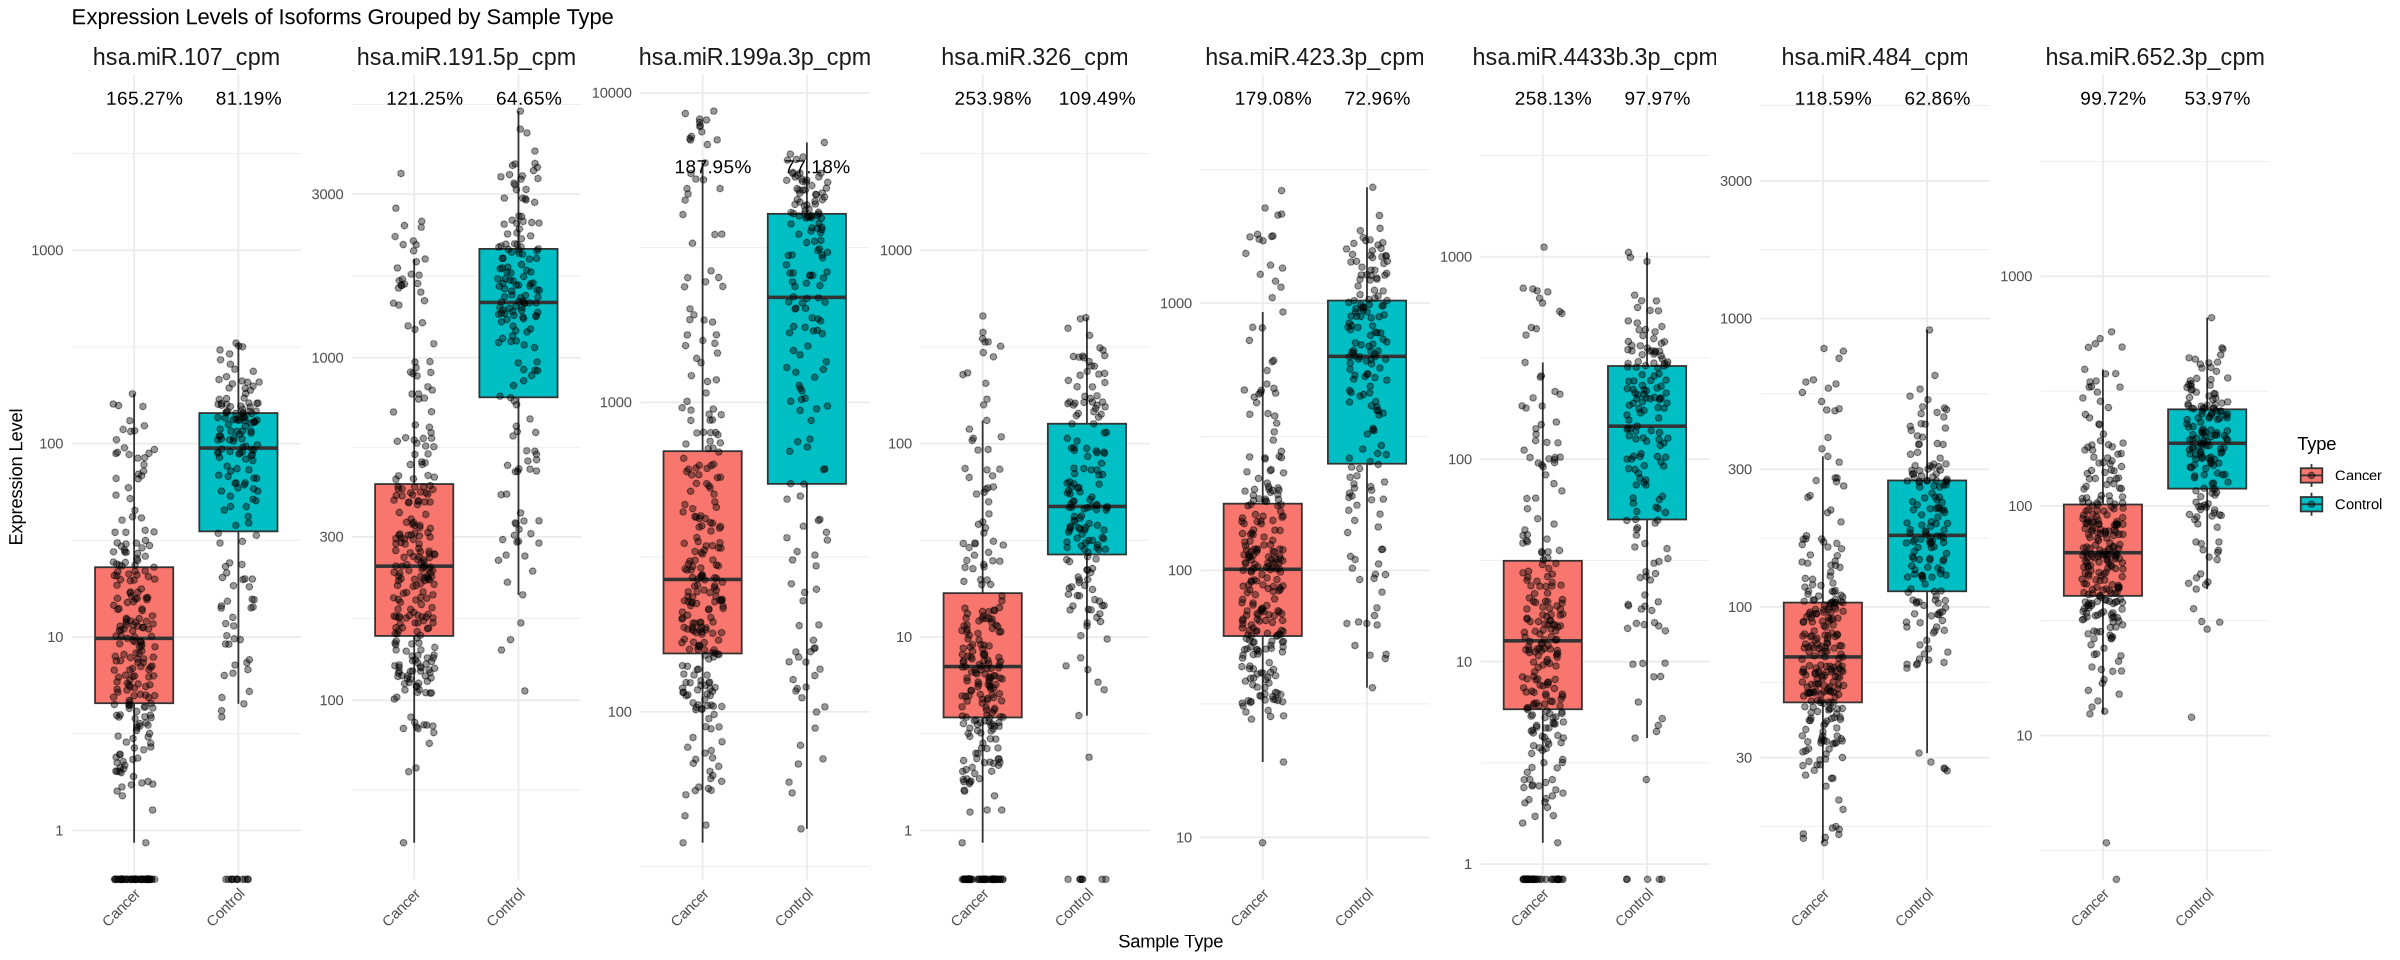

In [28]:
show_marker_exp_boxplot(results_list$mature_cpm$final_features, mature_cpm, 20, 8)

## cpm

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 3929 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


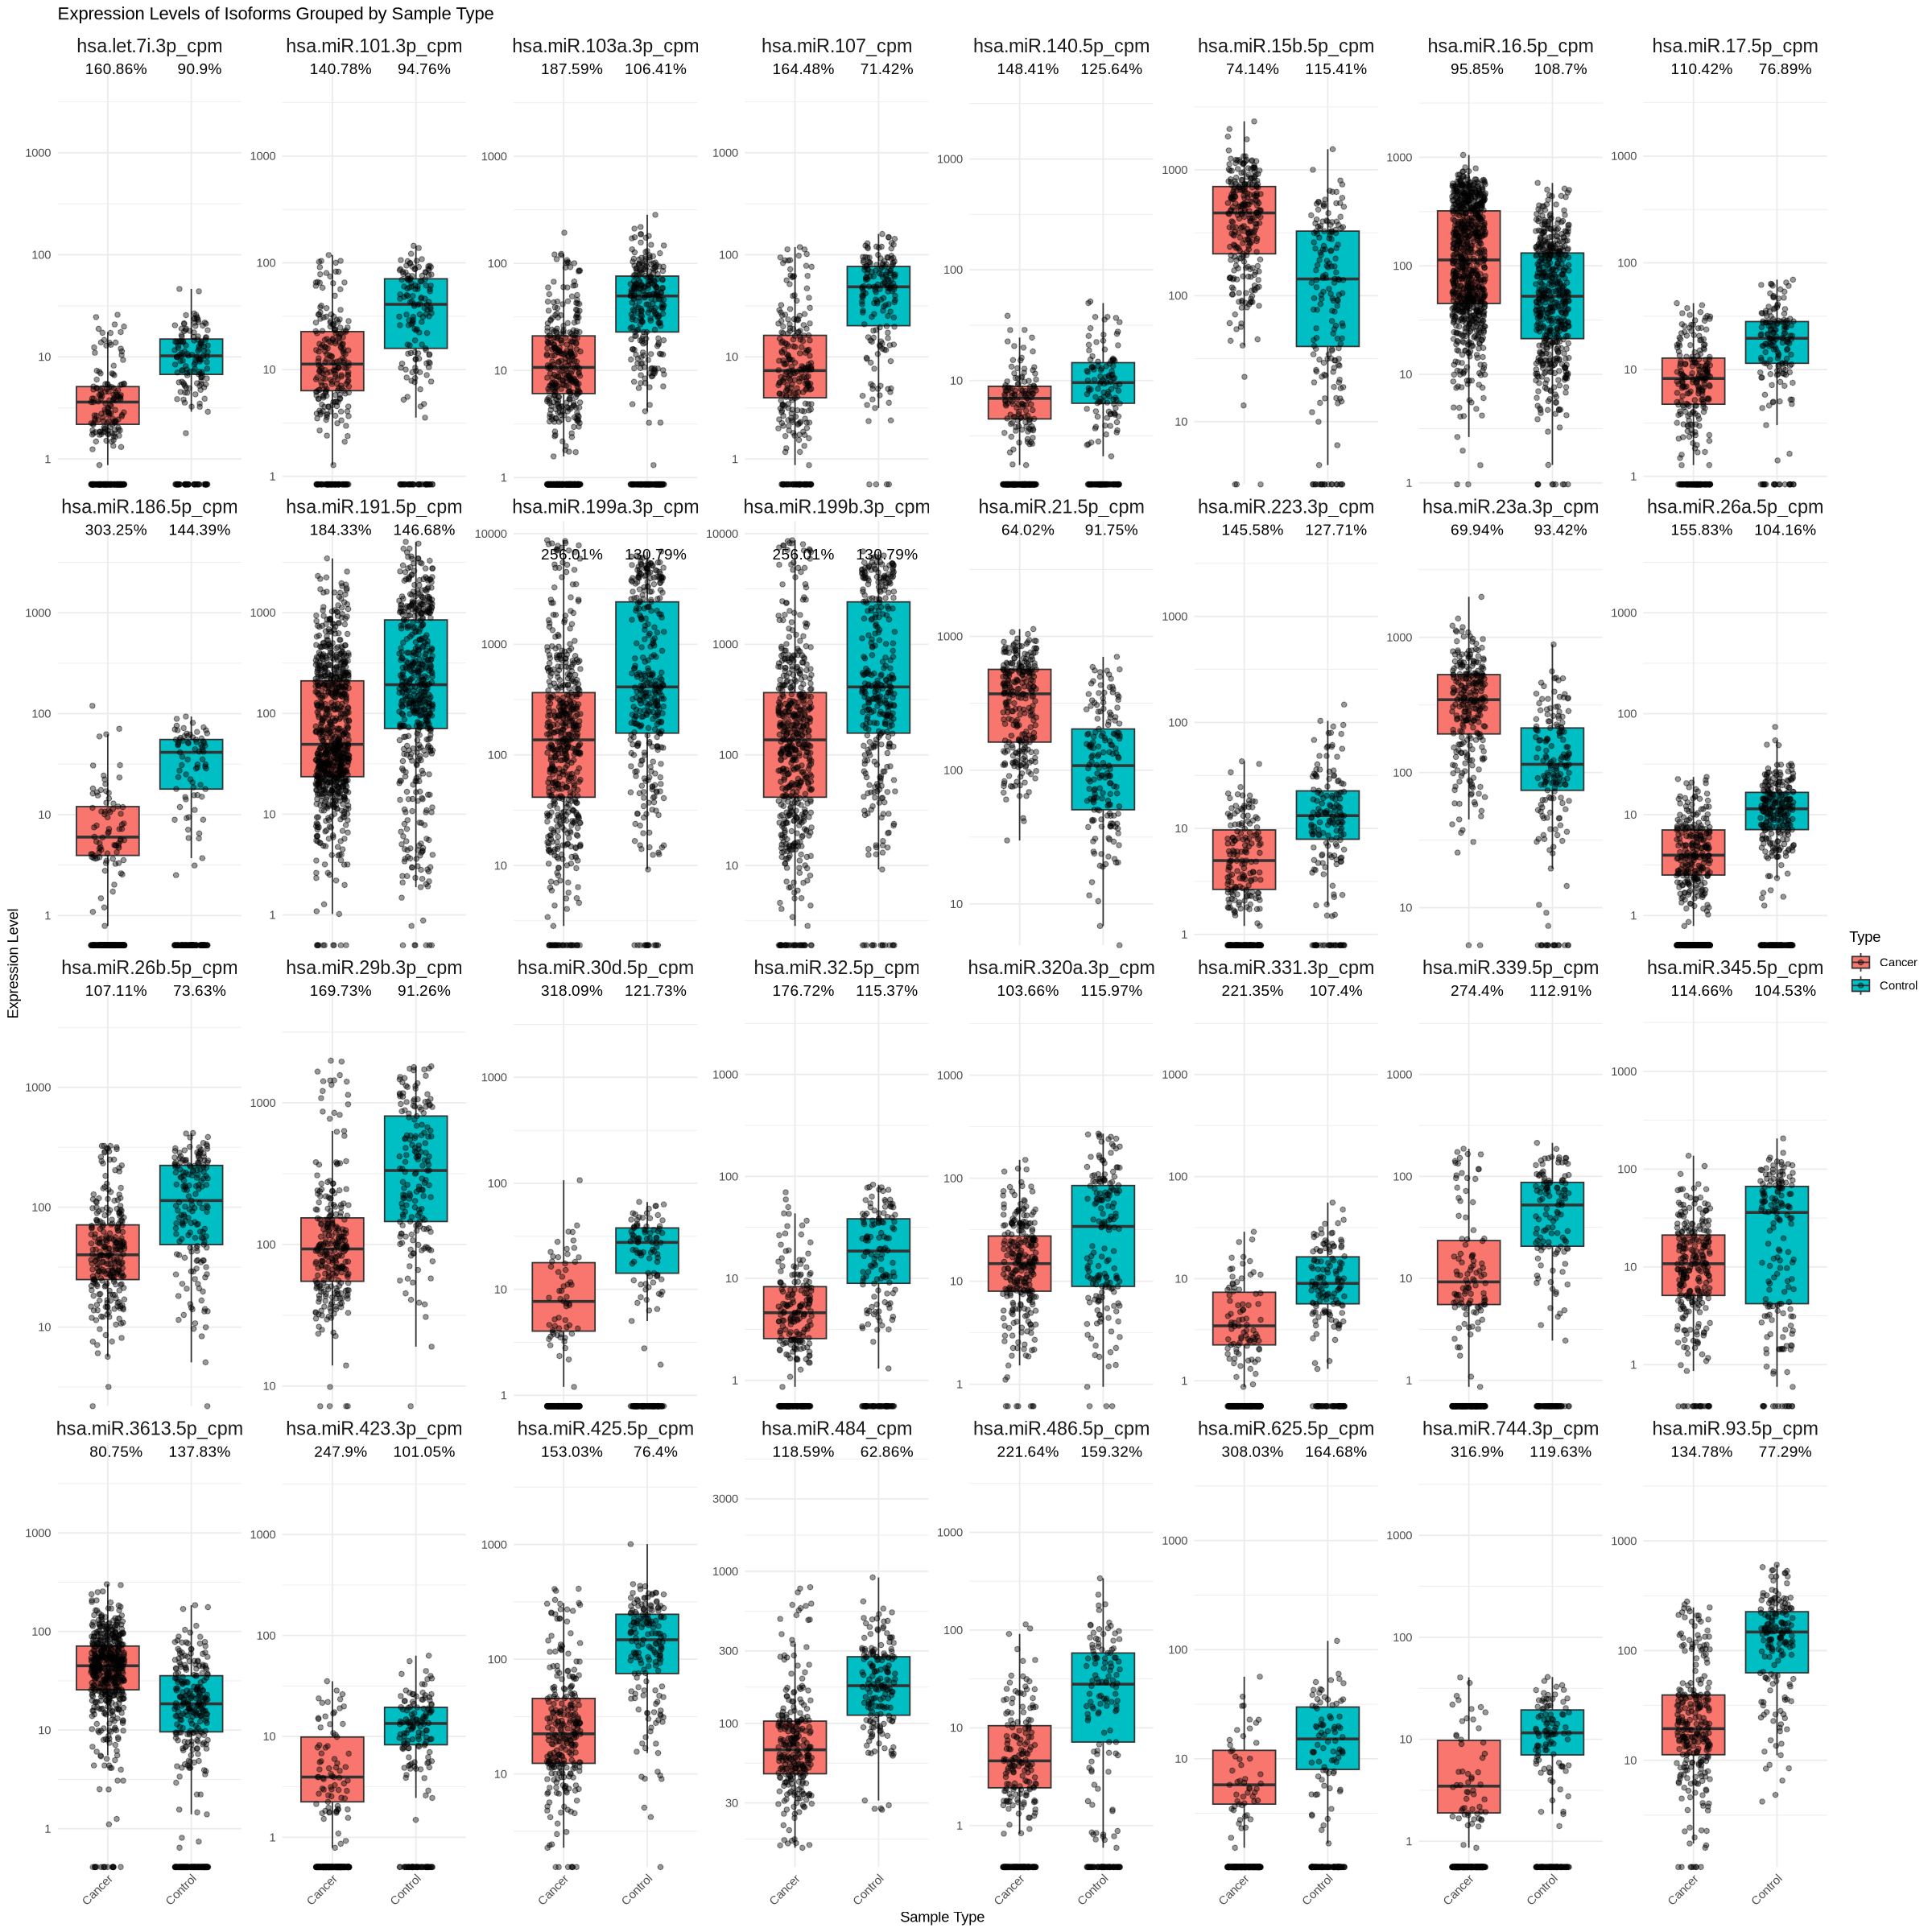

In [36]:
show_marker_exp_boxplot(results_list$cpm$final_features, cpm, 20, 20)

## raw_data

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1771 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


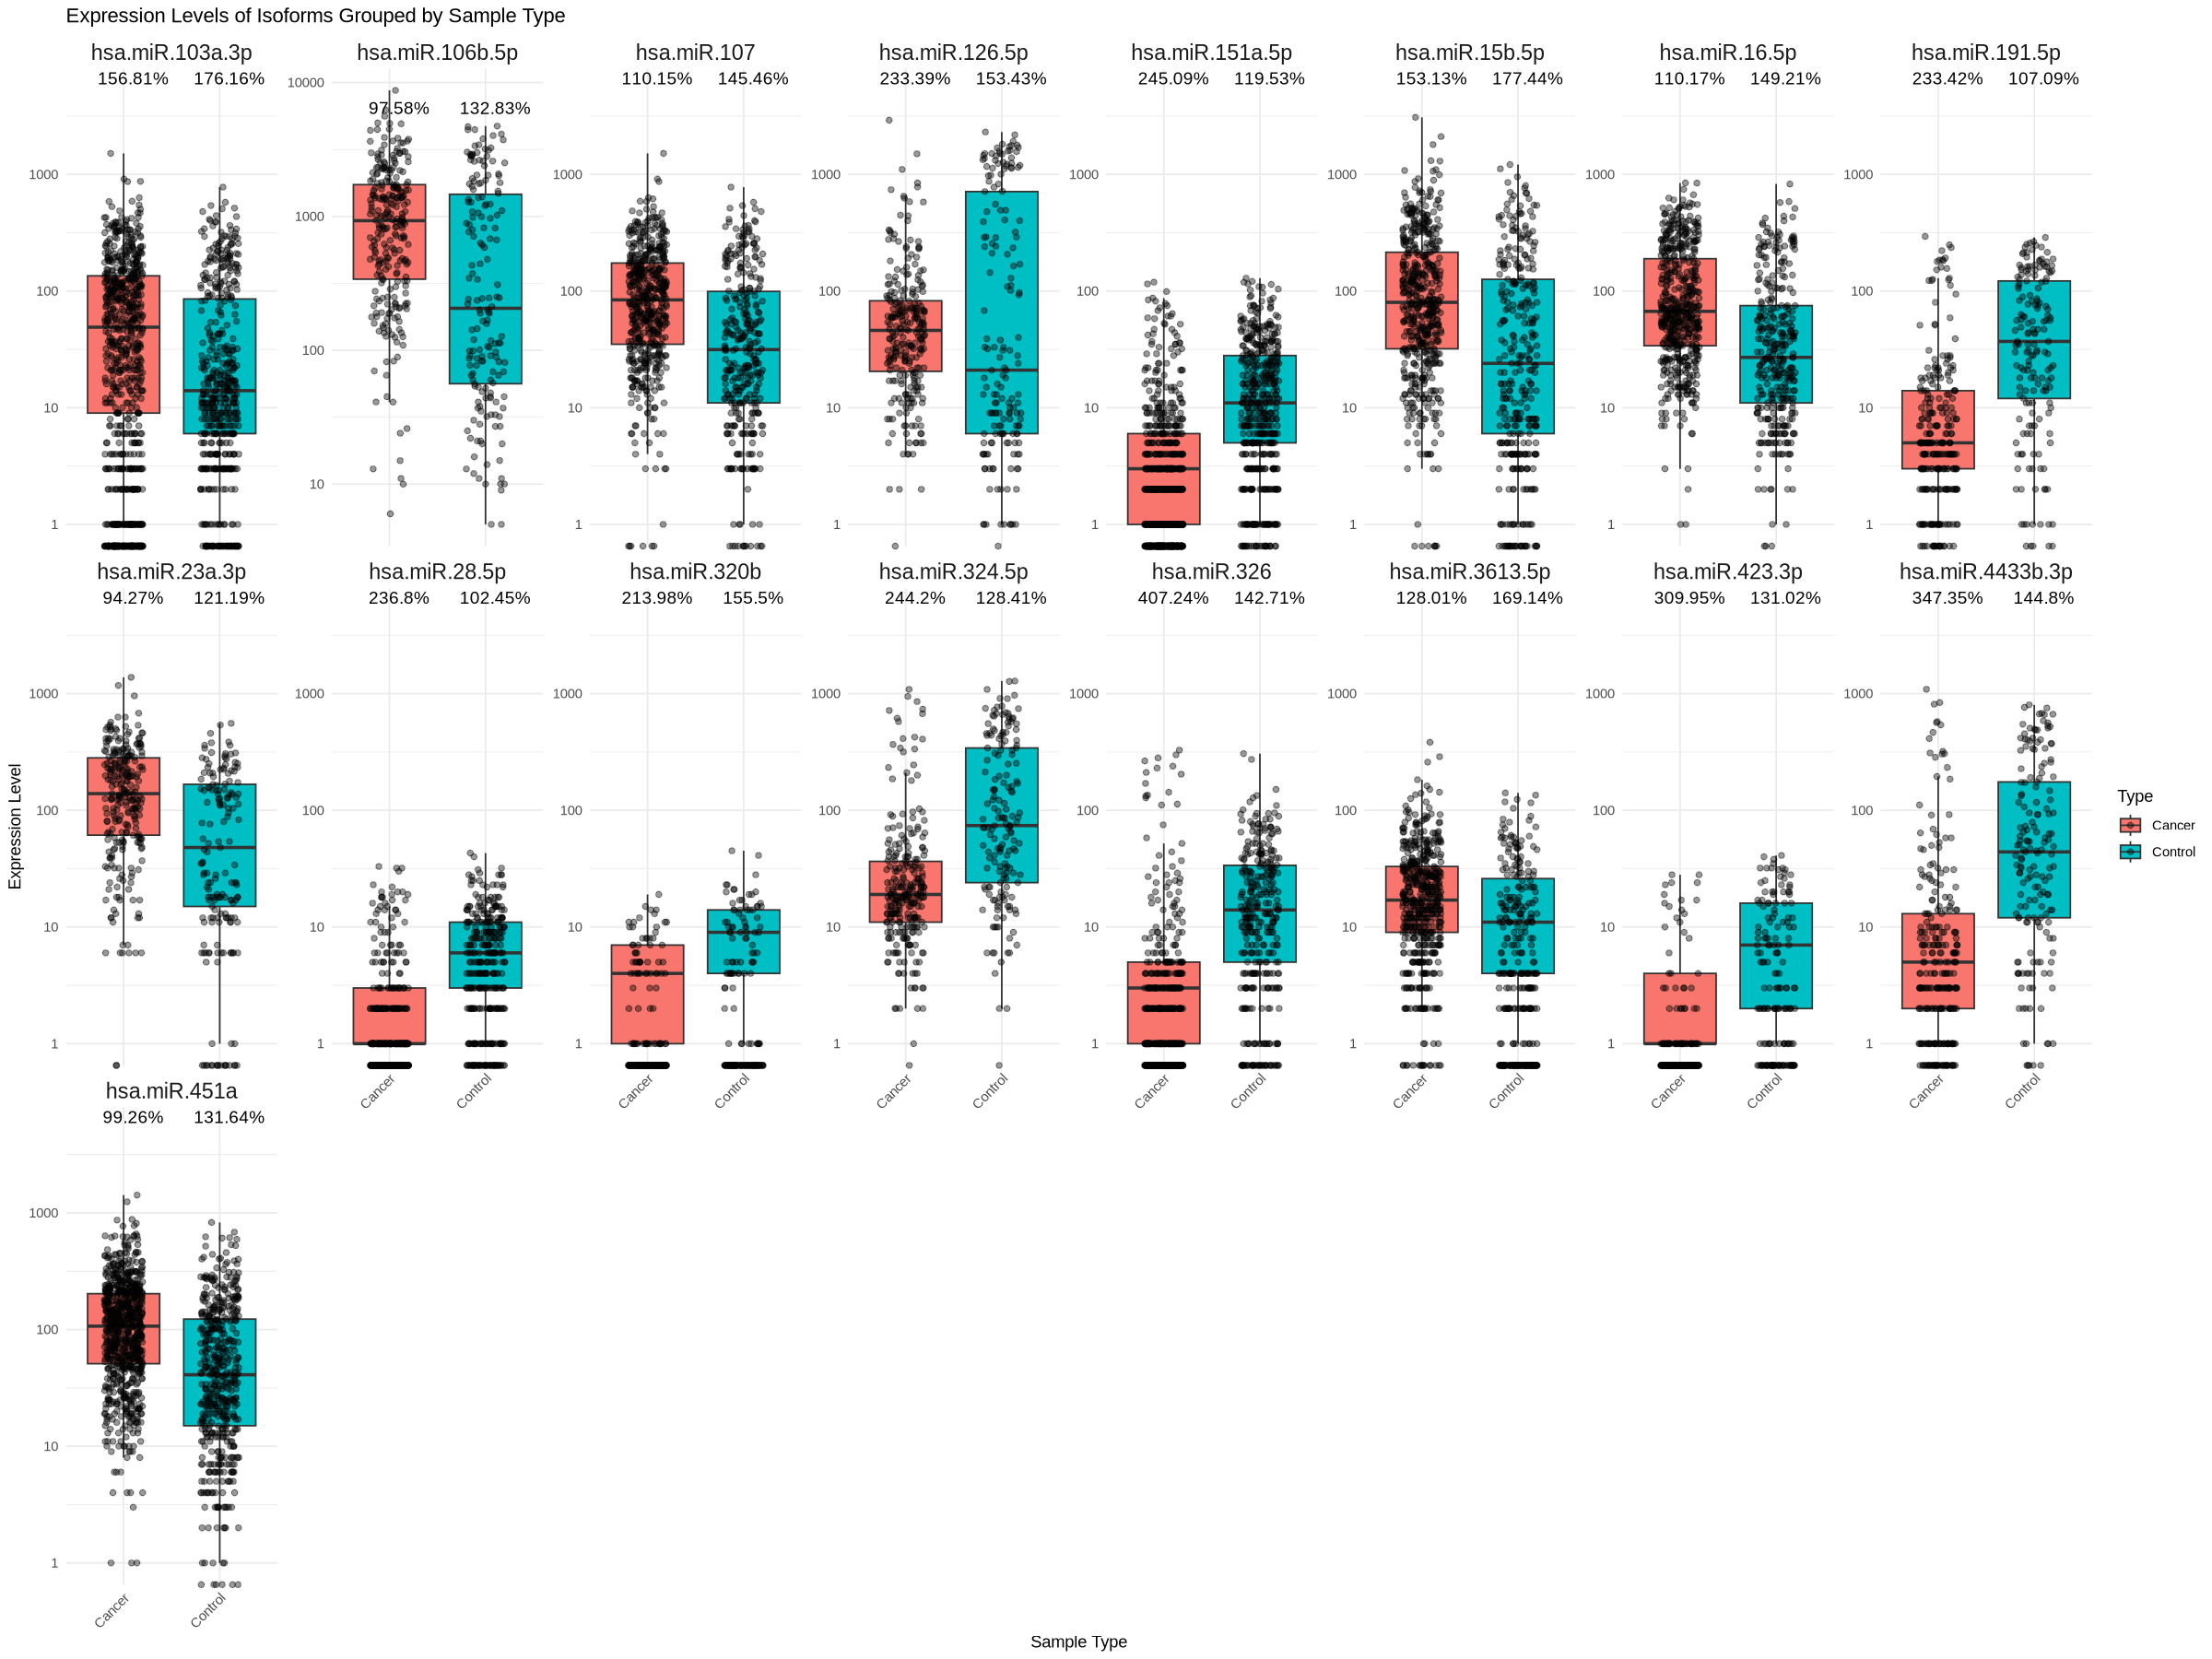

In [34]:
show_marker_exp_boxplot(results_list$raw_data$final_features, raw_data, 20, 15)

## cpm_combat

Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1090 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 1090 rows containing missing values or values outside the scale range
(`geom_point()`).”


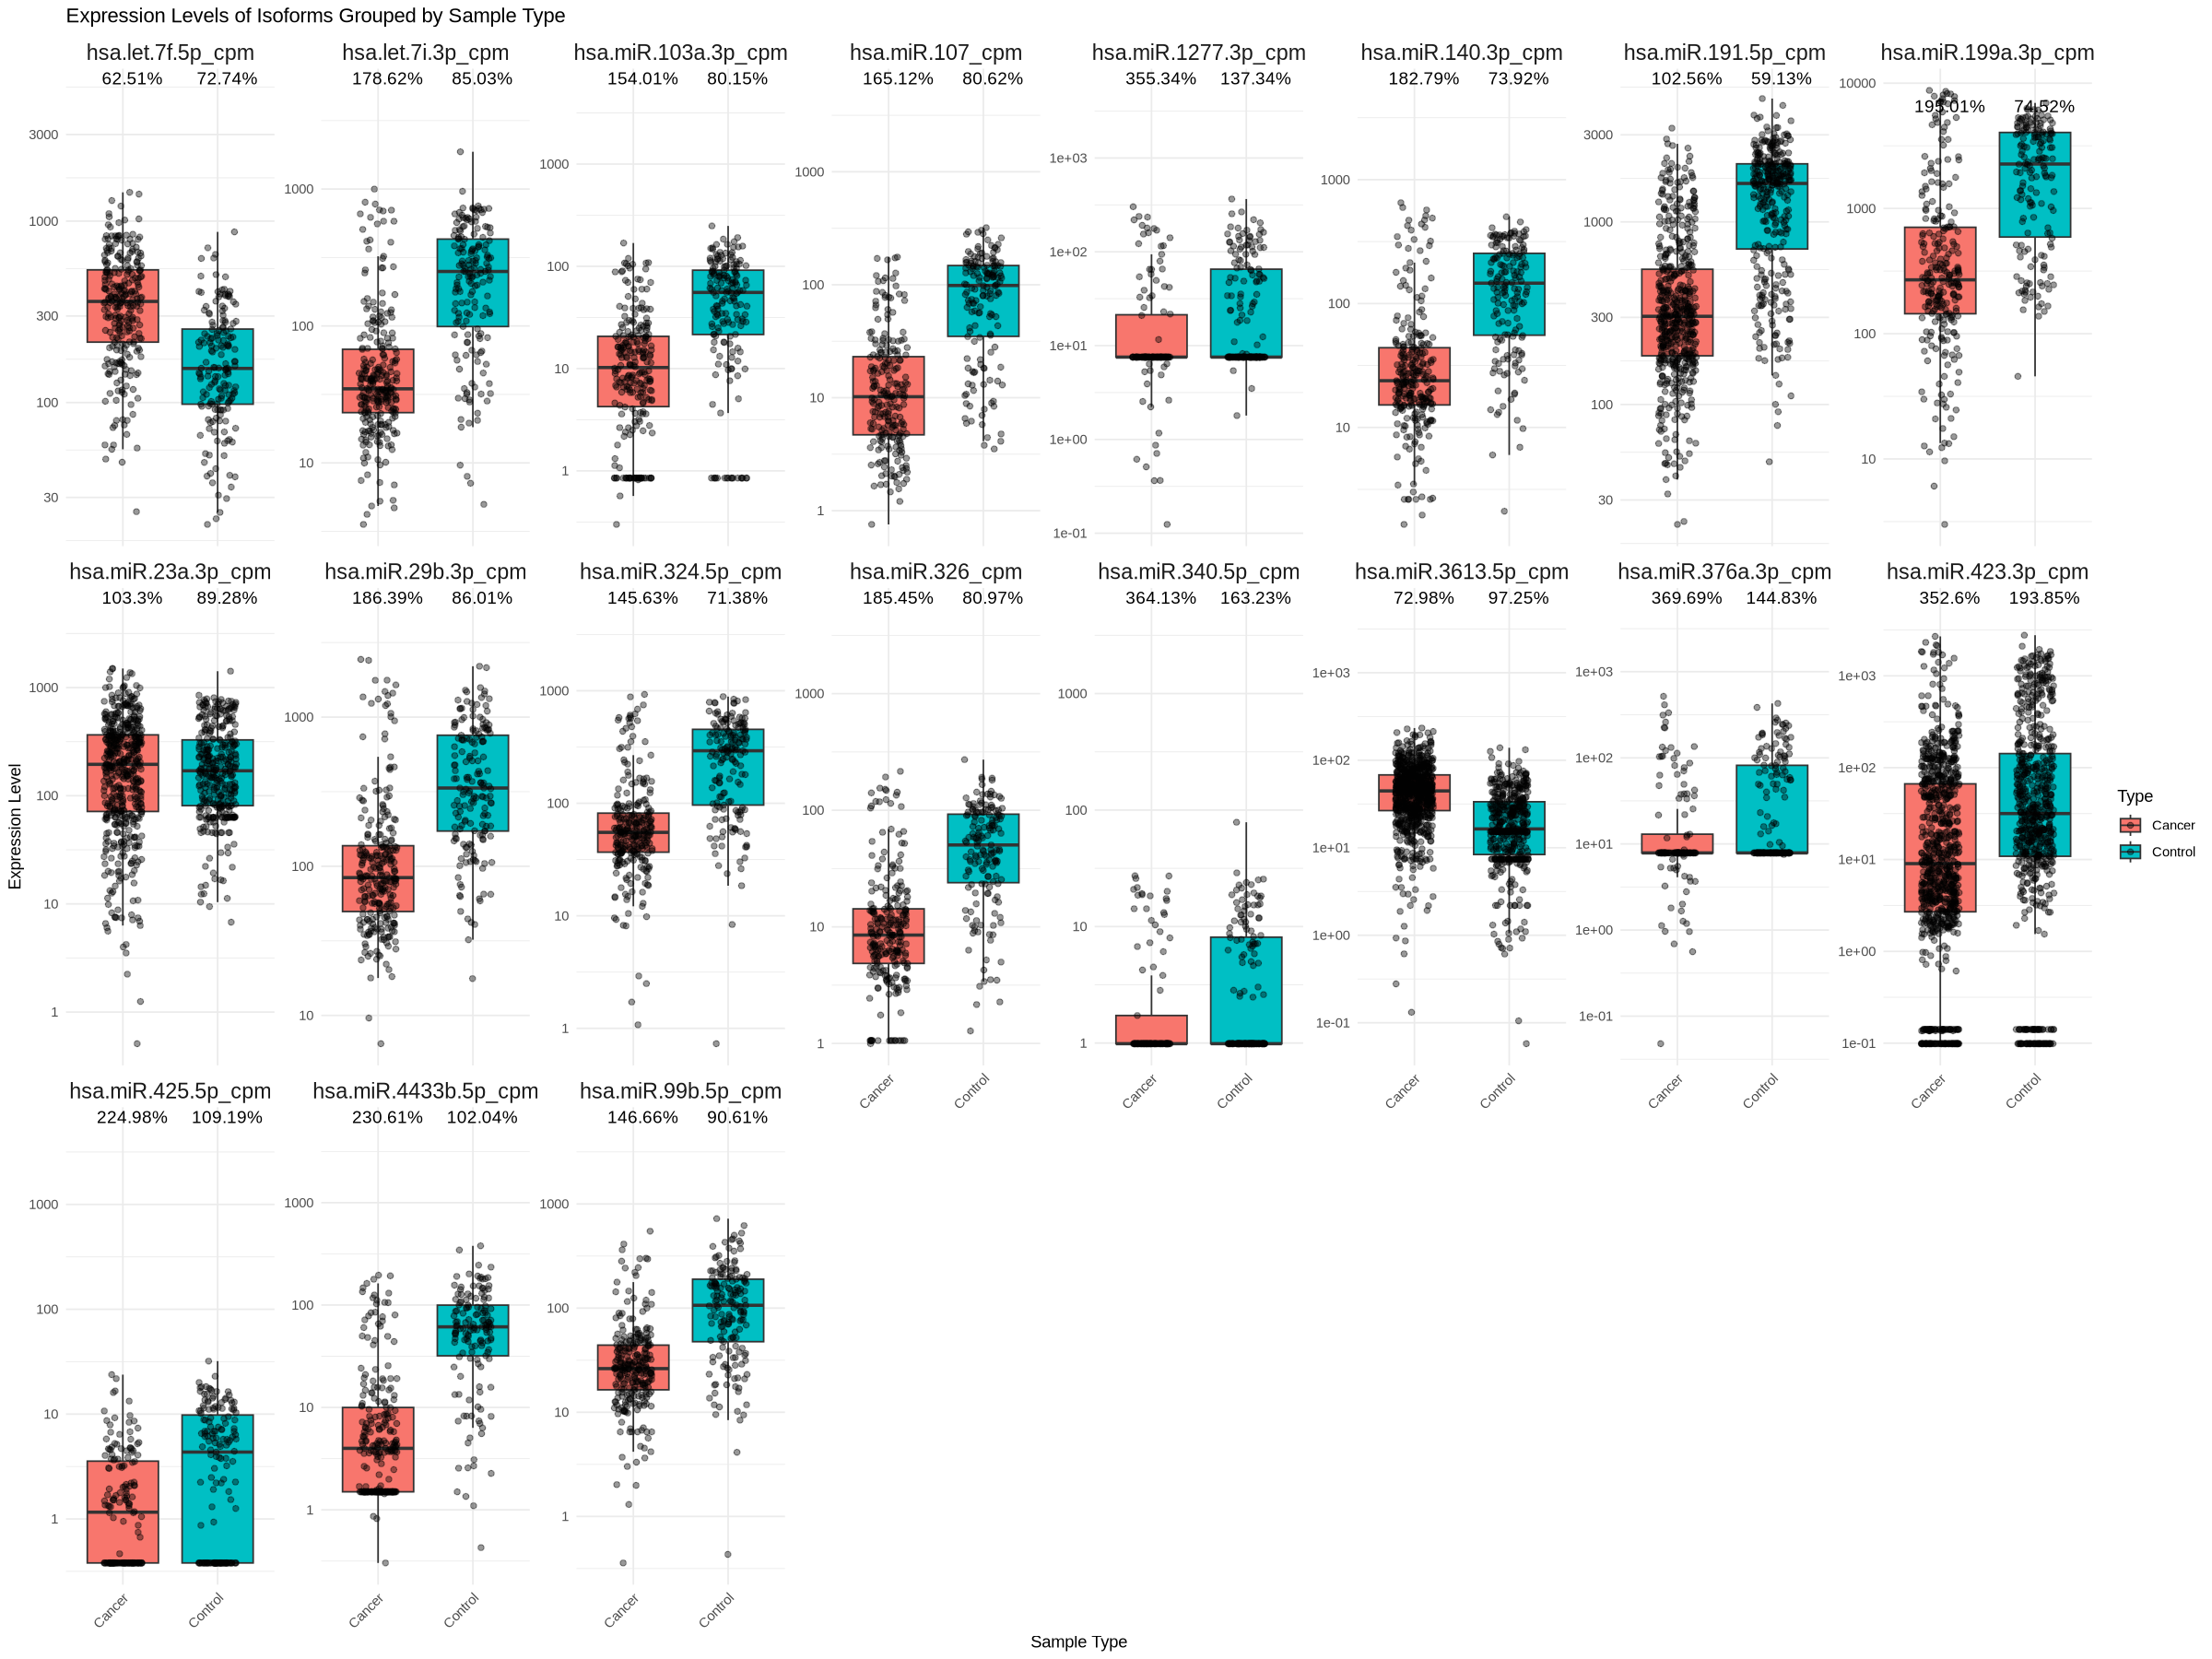

In [37]:
show_marker_exp_boxplot(results_list$cpm_combat$final_features, as.data.frame(cpm_combat), 20, 15)

## raw_ruvg

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1137 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


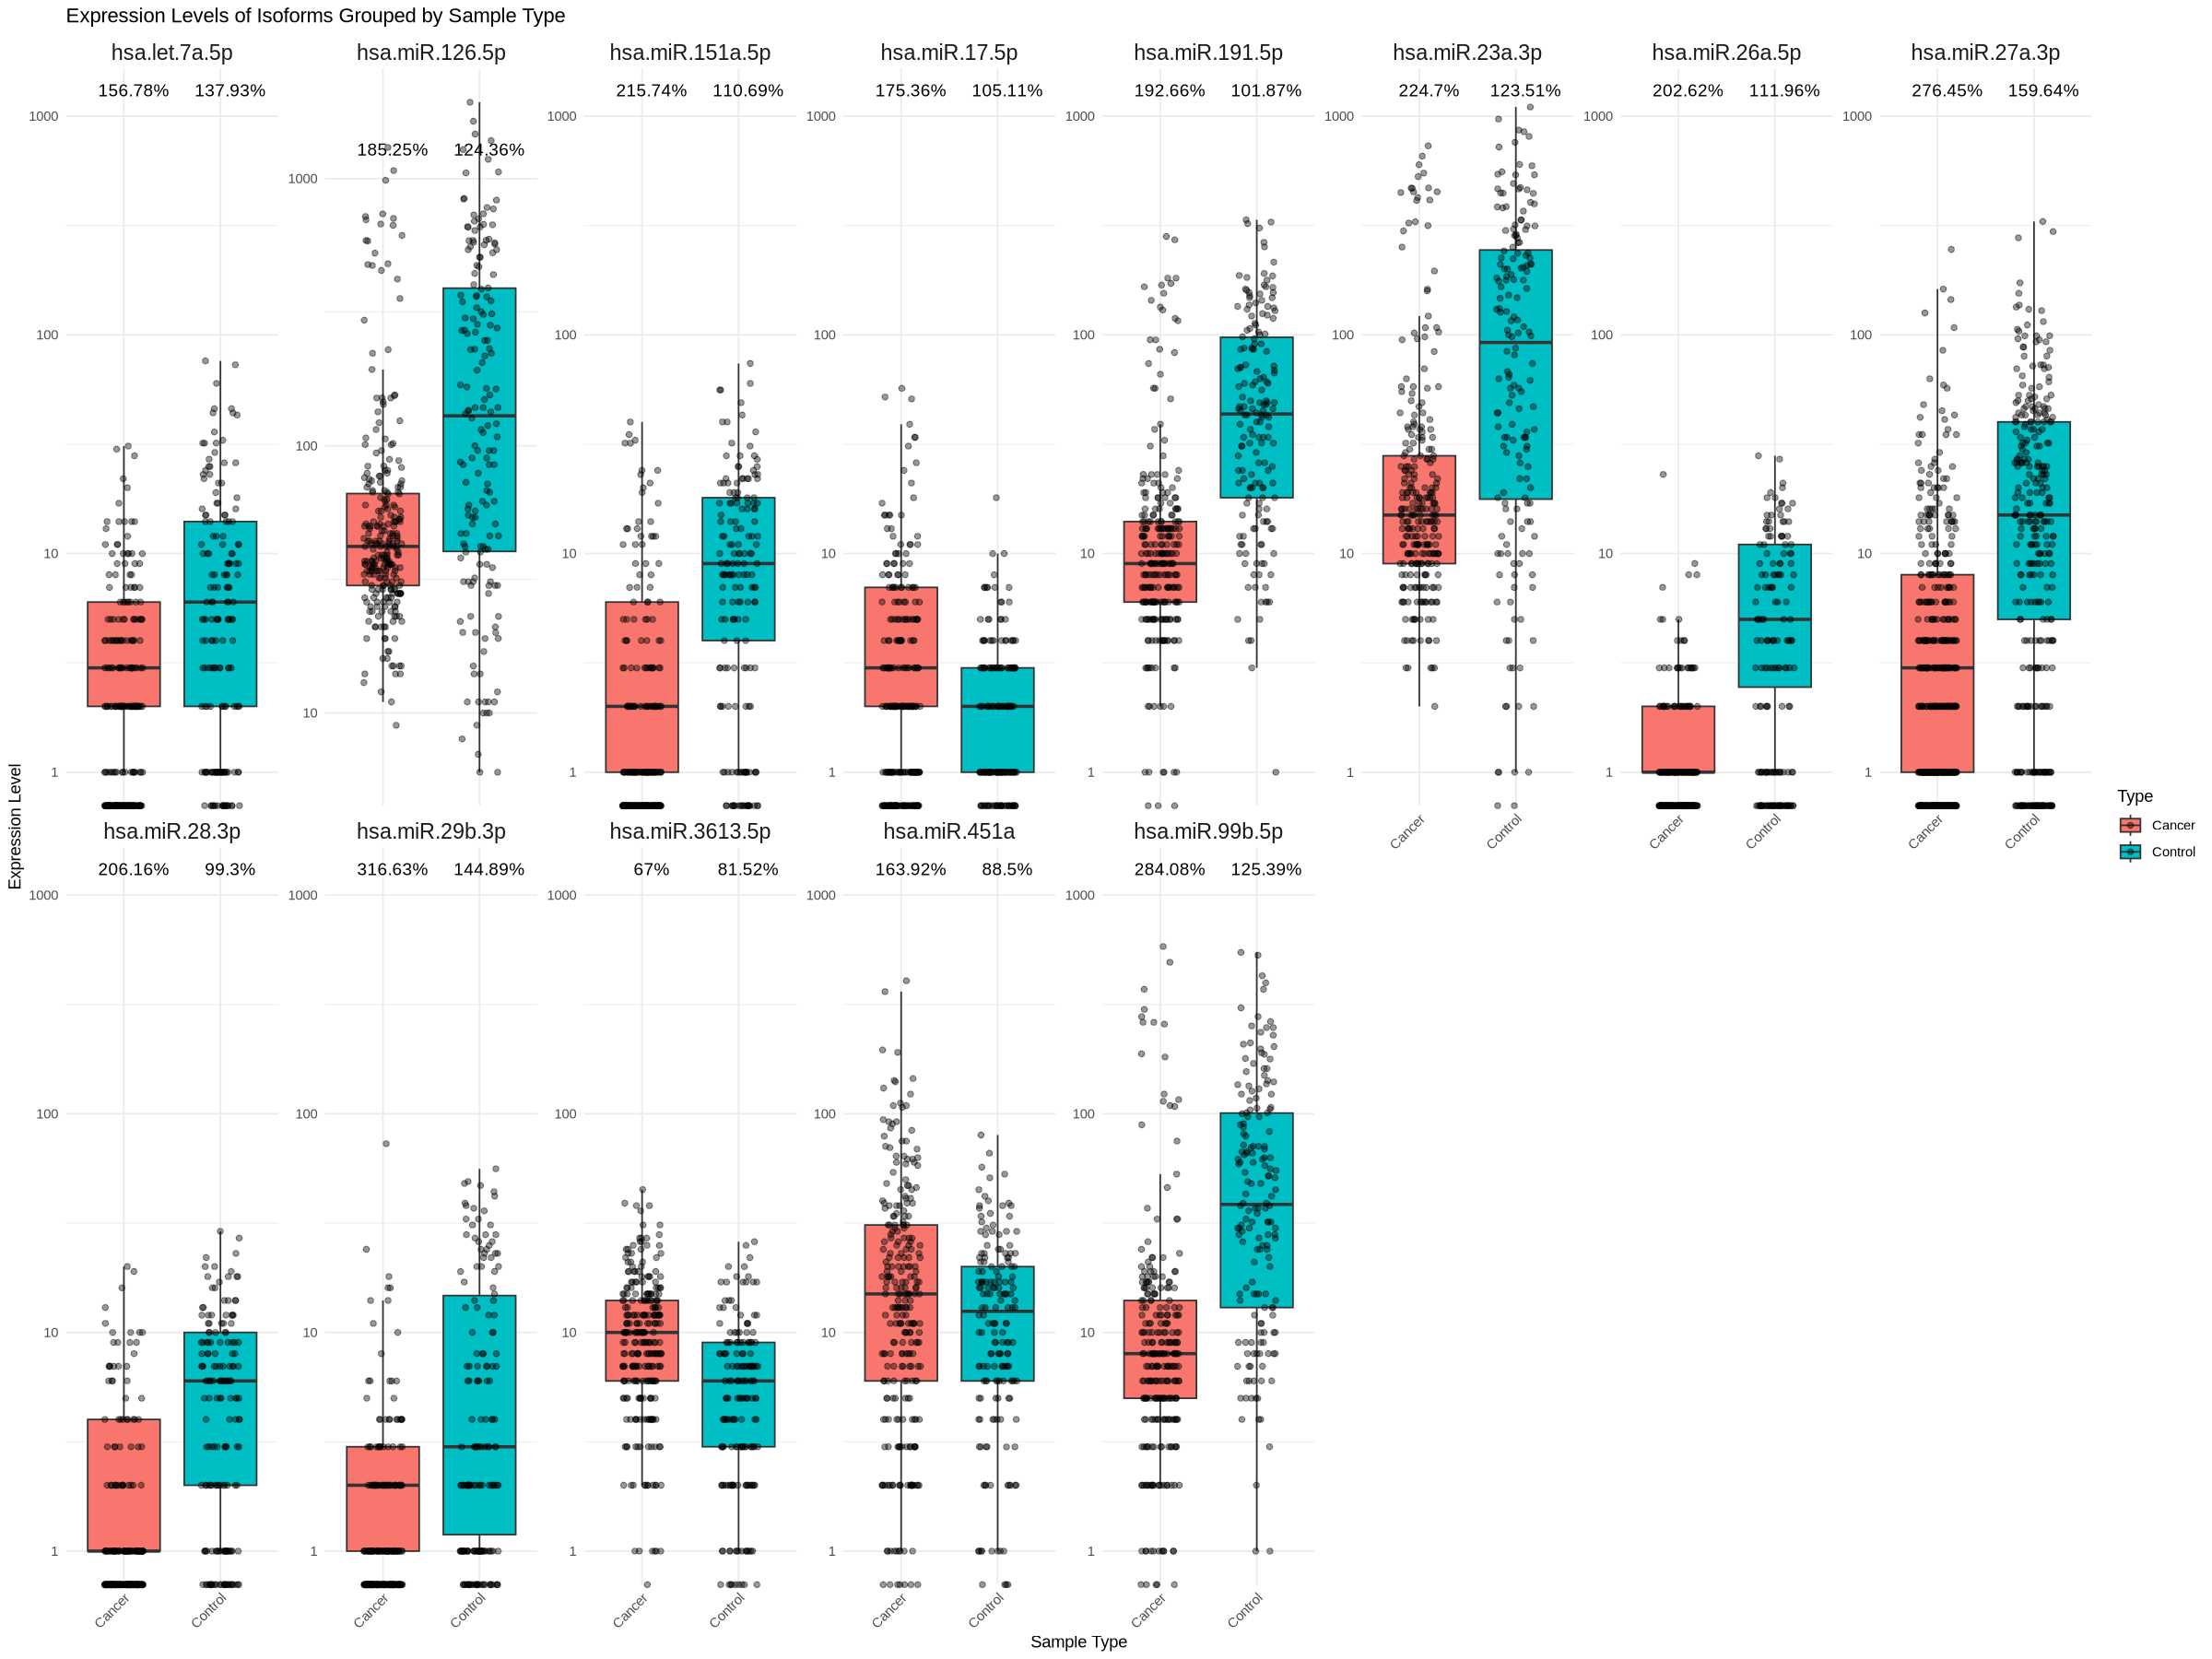

In [14]:
show_marker_exp_boxplot(results_list$raw_ruvg_edger$final_features, as.data.frame(raw_ruvg), 20, 15)

## raw_ruvg marker exp in 1000 samples

In [6]:
markers = gsub(".*_([^_]+)_.*", "\\1", results_list$raw_ruvg_edger$final_features)
markers

[1] "ATTACTTTTGGTACGCG"      "CACATTGCCAGGGATTTCCA"   "TGTTGTACTTTTTTTTTG"    
 [4] "CACCCGTAGAACCGACCTTGCG" "CAGTGGCTAACTTCCGC"      "CAGTGGCTAAGTTCCCC"     
 [7] "GTGCTTAGAGTGCAGGTA"     "ACCATTTGAAATCAGTGTT"    "AGGTAGTAGGTTGTATAGTT"  
[10] "TCGAGCAGCTCACAGTCTAGTA" "CACTAGATTGTGAGCTCCTGCA" "AACGGAATCCCAAAAGCAGCTG"
[13] "GTTACCATTACTGAGTCT"     "TTGAAGTAATCCAGGATAGGCT"

In [7]:
exp_1k = read.csv('/storeData/project/12-NH055-2/model/matrixinfo/normal/NH055-建模1007例和第一轮验证535例样本实验信息汇总20240913.2.0.0.20240927.matrix/03.isomirs/highRCpct_0.1/cpm.17895.matrix.csv')

rownames(exp_1k) = exp_1k$Sequence
exp_1k = exp_1k[, -1]

In [32]:

marker = intersect(markers, rownames(exp_1k))
ind = match(marker, markers)
marker_longname = results_list$raw_ruvg_edger$final_features[ind]


In [34]:
sample_info_1k  = read.csv('/storeData/project/12-NH055-2/model/matrixinfo/normal/NH055-建模1007例和第一轮验证535例样本实验信息汇总20240913.2.0.0.20240927.matrix/02.meta/NH055-建模1007例和第一轮验证535例样本实验信息汇总20240913.judgeqc.2.0.0.20240927.meta.group.csv')
sample_info_1k$Sample = make.names(sample_info_1k$Library_ID)
head(sample_info_1k)


Library_ID                    Group        Type Sample                       
1 R10TR02P240631060-1-1-001-001 control      0    R10TR02P240631060.1.1.001.001
2 R10TR02P240325832-1-1-002-002 CRC-stageIII 1    R10TR02P240325832.1.1.002.002
3 R10TR02P240631101-1-1-003-003 control      0    R10TR02P240631101.1.1.003.003
4 R10TR02P240530550-1-1-004-004 control      0    R10TR02P240530550.1.1.004.004
5 R10TR02P240631757-1-1-006-006 CRC-stageII  1    R10TR02P240631757.1.1.006.006
6 R10TR02P240429447-1-1-007-007 control      0    R10TR02P240429447.1.1.007.007

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 142 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


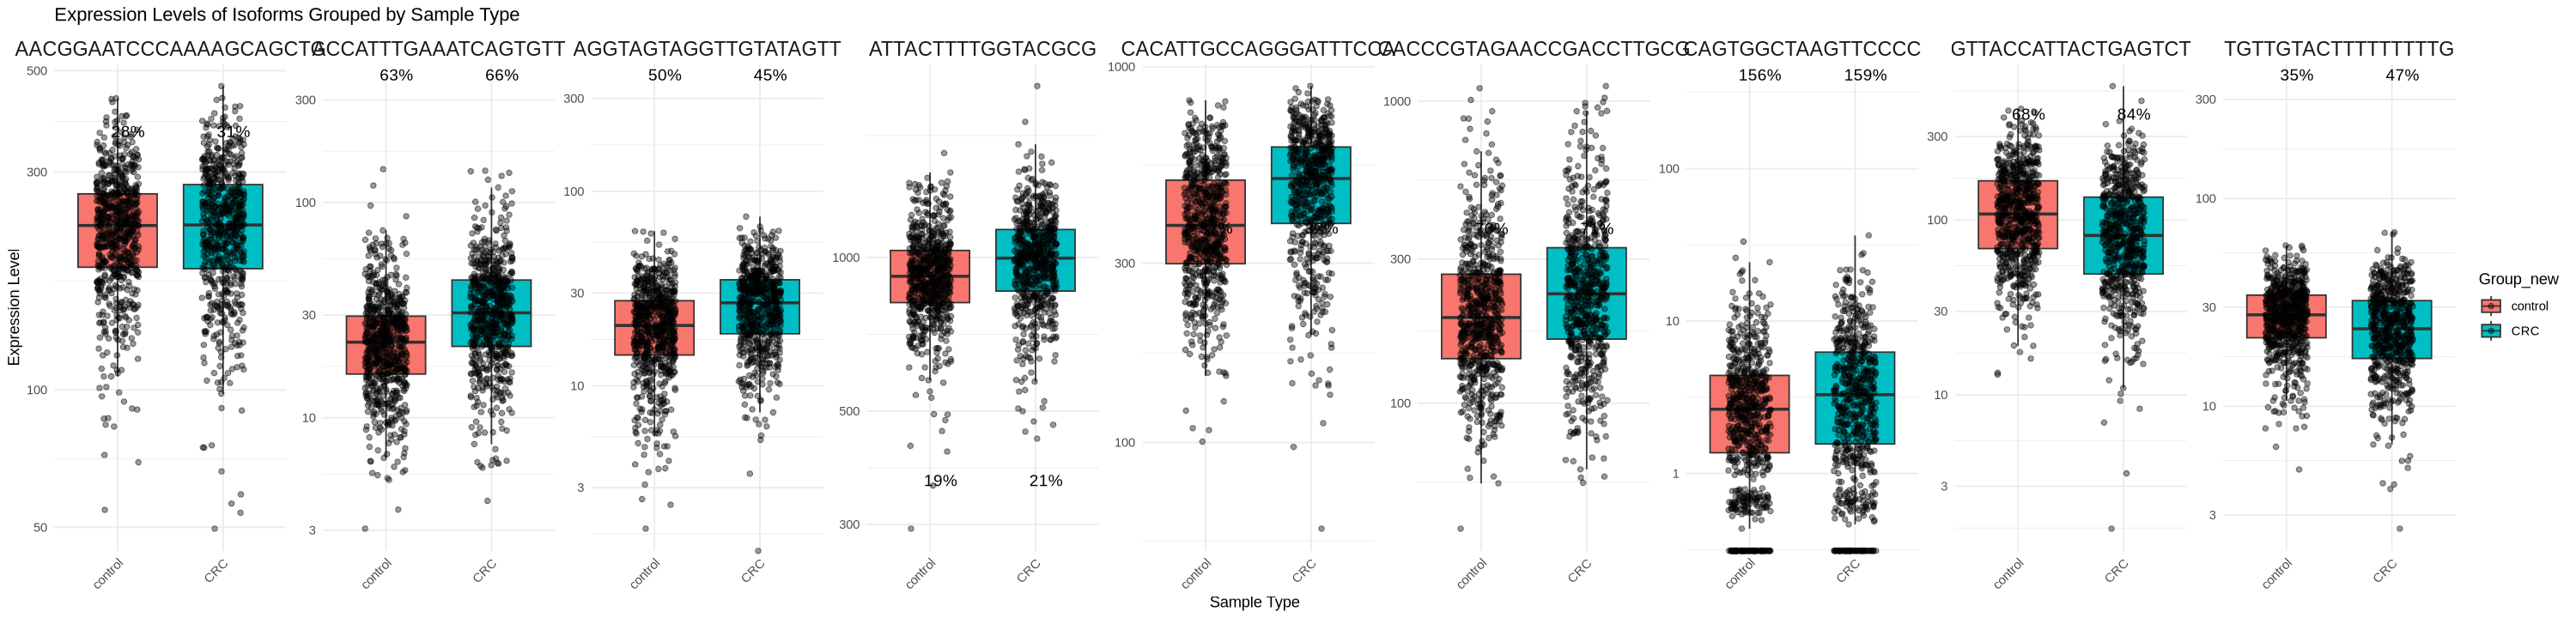

In [52]:
width = 25
height = 6
exp.df = exp_1k


exp.df_sp = exp.df[marker, ]
# Add isoform information as a new column in the dataframe
exp.df_sp$Isoform <- rownames(exp.df_sp)

# Reshape the dataframe to long format (now including Isoform information)
iso_long <- pivot_longer(exp.df_sp, cols = starts_with("R"), names_to = "Sample", values_to = "Expression")

# Merge with sample info
iso_long <- merge(iso_long, sample_info_1k, by = "Sample")  

iso_long = iso_long %>% filter(!Group=='CRC-stage无法分期') %>% mutate(Group_new = sub('CRC.+', 'CRC', Group))

change_figure_size(width, height)

p = ggplot(iso_long, aes(x = Group_new, y = Expression, fill = Group_new)) +
    geom_boxplot(outlier.shape = NA) +  
    geom_jitter(width = 0.2, alpha = 0.4) +  
    facet_wrap(~Isoform, scales = "free_y", ncol = 9) + 
    scale_y_log10() +
    labs(title = "Expression Levels of Isoforms Grouped by Sample Type", x = "Sample Type", y = "Expression Level") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels
    strip.text = element_text(size = 14))  # Adjust facet label text size

cv_data <- iso_long %>% 
    group_by(Group_new, Isoform) %>%
    summarize(CV = sd(Expression, na.rm = TRUE) / median(Expression, na.rm = TRUE) * 100, .groups = 'drop')  # CV in percentage

p = p + geom_text(data = cv_data, 
    aes(x = Group_new, y = mean(iso_long$Expression, na.rm = TRUE) * 1.5, 
    label = paste0(round(CV, 0), "%")), 
    vjust = -0.5, size = 4, 
    position = position_nudge(x = 0.1)) +  
    coord_cartesian(clip = 'off')  

p

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


Warning message:
“Removed 384 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


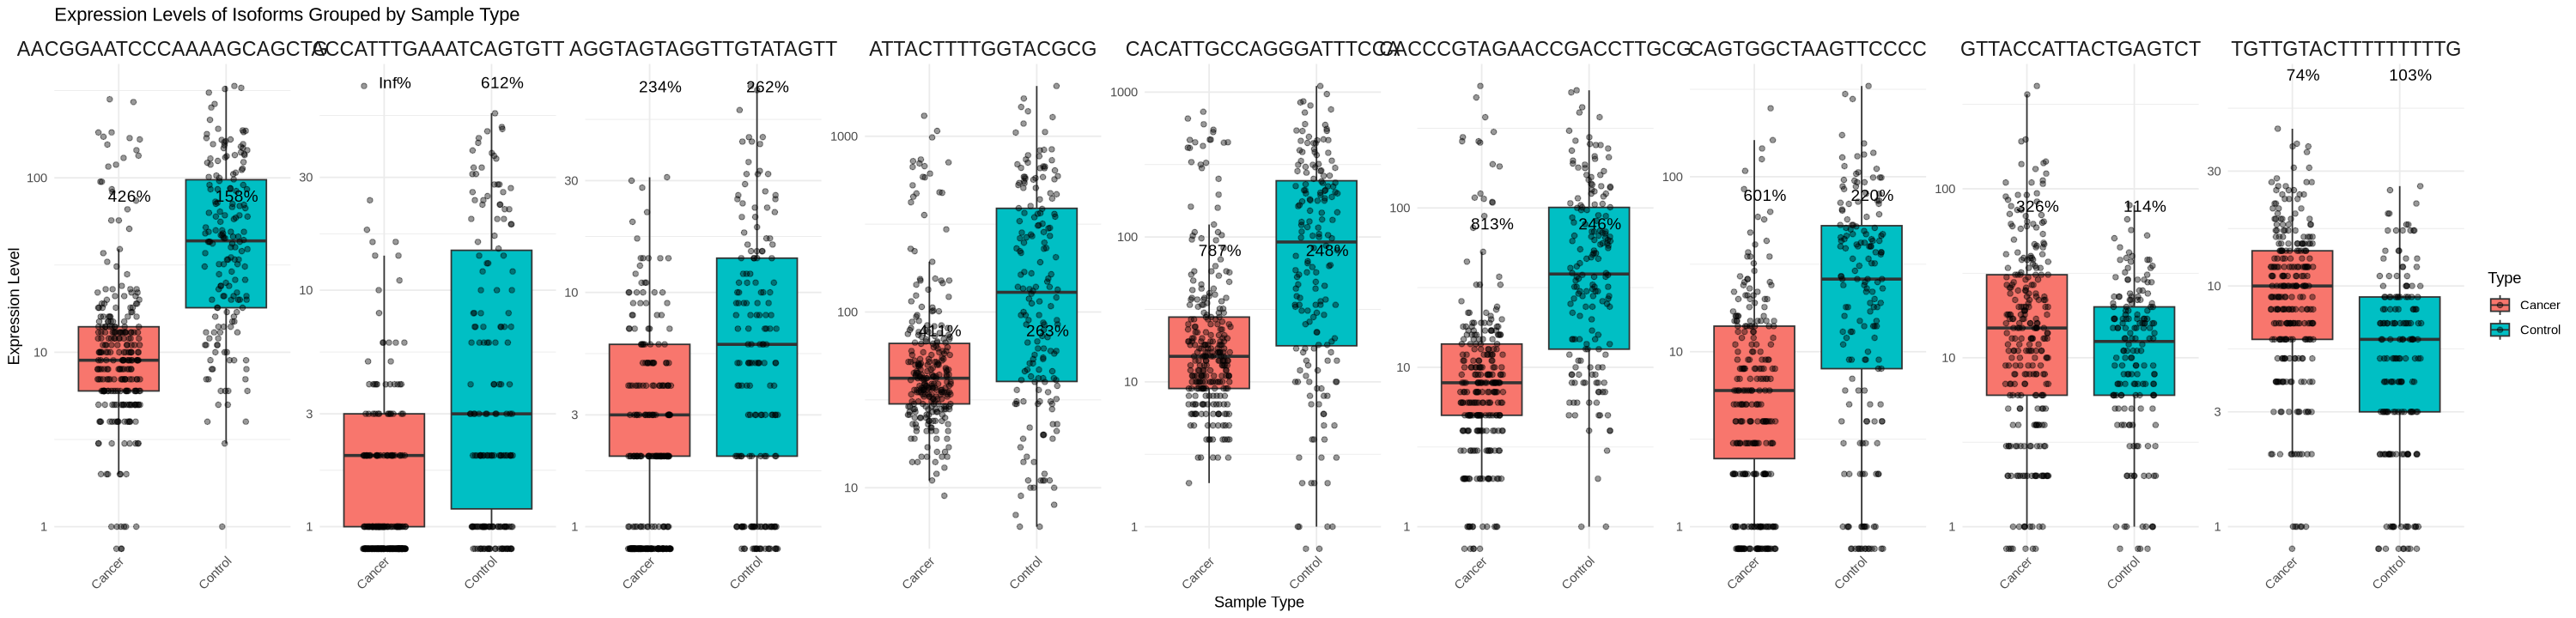

In [87]:
width = 25
height = 6
exp.df = as.data.frame(raw_ruvg[, samples.train])
rownames(exp.df) = make.names(rownames(exp.df))
exp.df_sp = exp.df[marker_longname, ]

rownames(exp.df_sp) = gsub(".*_([^_]+)_.*", "\\1", marker_longname)
# Add isoform information as a new column in the dataframe
exp.df_sp$Isoform <- rownames(exp.df_sp)

# Reshape the dataframe to long format (now including Isoform information)
iso_long <- pivot_longer(exp.df_sp, cols = starts_with("P"), names_to = "Sample", values_to = "Expression")

# Merge with sample info
iso_long <- merge(iso_long, sample_info, by.x = "Sample", by.y = 'sample')  

change_figure_size(width, height)

p = ggplot(iso_long, aes(x = Type, y = Expression, fill = Type)) +
    geom_boxplot(outlier.shape = NA) +  
    geom_jitter(width = 0.2, alpha = 0.4) +  
    facet_wrap(~Isoform, scales = "free_y", ncol = 9) + 
    scale_y_log10() +
    labs(title = "Expression Levels of Isoforms Grouped by Sample Type", x = "Sample Type", y = "Expression Level") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels
    strip.text = element_text(size = 14))  # Adjust facet label text size

cv_data <- iso_long %>% 
    group_by(Type, Isoform) %>%
    summarize(CV = sd(Expression, na.rm = TRUE) / median(Expression, na.rm = TRUE) * 100, .groups = 'drop')  # CV in percentage

p = p + geom_text(data = cv_data, 
    aes(x = Type, y = mean(iso_long$Expression, na.rm = TRUE) * 1.5, 
    label = paste0(round(CV, 0), "%")), 
    vjust = -0.5, size = 4, 
    position = position_nudge(x = 0.1)) +  
    coord_cartesian(clip = 'off')  

p

In [86]:
marker_longname


[1] "iso.17.I5ZYSHK_ATTACTTTTGGTACGCG_hsa.miR.126.5p"       
[2] "iso.20.2QX6REY6_CACATTGCCAGGGATTTCCA_hsa.miR.23a.3p"   
[3] "iso.18.9YUZZZ0P_TGTTGTACTTTTTTTTTG_hsa.miR.3613.5p"    
[4] "iso.22.2RS20U3YK_CACCCGTAGAACCGACCTTGCG_hsa.miR.99b.5p"
[5] "iso.17.J4QO7RJ_CAGTGGCTAAGTTCCCC_hsa.miR.27a.3p"       
[6] "iso.19.0QZBHPKE_ACCATTTGAAATCAGTGTT_hsa.miR.29b.3p"    
[7] "iso.20.1LSKZLVN_AGGTAGTAGGTTGTATAGTT_hsa.let.7a.5p"    
[8] "iso.22.B8DR2BPJP_AACGGAATCCCAAAAGCAGCTG_hsa.miR.191.5p"
[9] "iso.18.75JXN003_GTTACCATTACTGAGTCT_hsa.miR.451a"

# Raw_ruvg markers 1K modeling and test

In [90]:
table(sample_info_1k$Group,sample_info_1k$Type)

table(sample_info_1k$Type)

                   
                      0   1
  control           707   0
  CRC-stage0          0   3
  CRC-stageI          0 110
  CRC-stageII         0 178
  CRC-stageIII        0 278
  CRC-stageIV         0  85
  CRC-stage无法分期   0   1


  0   1 
707 655 

In [101]:
sample_info_1k_v1  = read.csv('/storeData/project/12-NH055-2/model/matrixinfo/normal/NH055-建模1007例和第一轮验证535例样本实验信息汇总20240913.2.0.0.20240927.matrix/02.meta/NH055-建模1007例和第一轮验证535例样本实验信息汇总20240913.judgeqc.2.0.0.20240927.meta.csv')

sample_info_1k_v1.train = sample_info_1k_v1 %>% filter(ModelGroup == '建模样本')
sample.train = sample_info_1k_v1.train$Library_ID

sample_info_1k_v1.validation = sample_info_1k_v1 %>% filter(ModelGroup == '第一轮验证')
sample.validation = sample_info_1k_v1.validation$Library_ID

In [104]:
rownames(sample_info_1k) = sample_info_1k$Library_ID
table(sample_info_1k[sample.train, 'Group'])
table(sample_info_1k[sample.validation, 'Group'])

table(sample_info_1k[sample.train, 'Type'])
table(sample_info_1k[sample.validation, 'Type'])


     control   CRC-stage0   CRC-stageI  CRC-stageII CRC-stageIII  CRC-stageIV 
         468            3           67          116          168           55 


          control        CRC-stageI       CRC-stageII      CRC-stageIII 
              239                43                62               110 
      CRC-stageIV CRC-stage无法分期 
               30                 1 


  0   1 
468 409 


  0   1 
239 246 